<div class="burk">
imports</div><i class="fa fa-lightbulb-o "></i>

# imports

In [1]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist
from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from SampleLists.SampleFileFunctions import *

import os
from Utils import cacheOnDisk
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

done1
stop
stop
done1
stop
done
done


In [2]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

'30042018'

# PNP515_ss15000_rep2

## merge permCorr and permFisher
correlation-spearman, 9998 permutations, min p-pvalue=0.0001
fisher - 9999 permutations, min p-pvalue=0.0001

thresholds - top 250 species and sequences
MbDF used = PNP515 samples, only swabs, minReads=9000000

In [ ]:
MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'


#load PNP515 sample list:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP515','rb') as fp:
    PNP515=pickle.load(fp)
print len(PNP515)
print PNP515[:5]


datasetFolder='%s/TCR_real_data/SubSampled15000data_rep2' %MyPath
datasetName='PNP515_ss15000_rep2'

gen_mb=False
mbLevel='s'
mbDataFolder='AllSeqProjects'
SampleList=PNP515
SampleListName='PNP515'
filterGenotek=True
filterMinimalReads=9000000

# (NsharedSamplesForSpecies,NsharedSamplesForSeqs,topNspecies,topNseqs):
thresholdList=[(None,None,250,250)]
outlierSTD=None
corrTest='spearman'
completecorrelation=True
correlationForHeatMap=False

usePermCorr=True
runFisher=False
runCorr=False
usePermFisher=True
nPermCorr=None
nPermFisher=None
firstPermCorr=None
firstPermFisher=None
runRealCorr=False
runRealFisher=False



merged_fisher_correlation_withIdentity=TCR_Mb_interactions_for_dataset(datasetFolder, datasetName, gen_mb, mbLevel, mbDataFolder, SampleList,
                                    SampleListName, filterGenotek, filterMinimalReads,filterlibPrepMethod,
                                    thresholdList, outlierSTD, corrTest, completecorrelation,
                                    correlationForHeatMap,usePermCorr,runCorr,runFisher,usePermFisher,nPermCorr,nPermFisher,
                                    firstPermCorr,firstPermFisher,runRealCorr,runRealFisher)



## define function to plot seq-pair relations

In [212]:
def plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,onlyNextera,outlierSTD=None):

    if onlyNextera:
        print 'loading most updated Mb file...filtered by libPrepMethod'
        f1 = '%s/MicrobiomeDataTables/FilteredAndMergedOnBD/\
MPA_s_AllSeqProjects_SampleListPNP515_filterGenotekTrue_filterMinimalRead9000000_libMethNextera_meannSTDNonenMinSamplesNone_fOutlierSampleFalse_fSamePersonFalse' % MyPath
    else:
        print 'loading most updated Mb file...NOT filtered by libPrepMethod'
        f1 = '%s/MicrobiomeDataTables/FilteredAndMergedOnBD/\
MPA_s_AllSeqProjects_SampleListPNP515_filterGenotekTrue_filterMinimalRead9000000_meannSTDNonenMinSamplesNone_filterOutlierSampleFalse_filterSamePersonFalse' % MyPath
    groupedFilteredMB = pd.read_pickle(f1)
       
        
    # (2) prepare MB and TCR files for analysis:
#     print 'preparing mb and TCR files for analysis:...'
    
    # prepare MB file:
    # load BD_FD converter, to make sure we remove BD_FD columns from the MB file:
    f1 = '%s/Sample files/updatedBDandFDlists/final_BD_FD_converter_mergedOnYear_RCfolderAllSeqProjects_30042018' % MyPath
    BD_FD = pd.read_pickle(f1)
    
    try:
        MbDF_RA = groupedFilteredMB.set_index('BD')  #### very important!!
    except KeyError:
#         print 'couldnt reset index to BD,probably BD is already the index'
        MbDF_RA = groupedFilteredMB
        

    # remove unnecessary columns:
    for column in BD_FD.columns.values:
        if column in MbDF_RA.columns.values:
#             print 'dropping %s column' % column
            MbDF_RA = MbDF_RA.drop(column, axis=1)
            
    # prepare TCR file:
    minNshared = 50  # add to function variables if necessary
    file1 = '%s/sharingAnalysis/sharingMatrix_%s_minNshared%s_RA' % (datasetFolder, datasetName, minNshared)
    TCRdf_RA = pd.read_pickle(file1)
    
    
    
    seqData = pd.DataFrame(TCRdf_RA[seq])
    seqData = seqData.rename(columns={0:seq})
    seqData = editSampleNames(seqData)
    speciesData = pd.DataFrame(MbDF_RA[species])
    merged = pd.merge(seqData, speciesData, how='inner', left_index=True, right_index=True)
#     print 'n rows after merging=%s' % len(merged)
    merged = filterSamePerson(merged,[0])
#     print 'n rows after same person removal=%s' % len(merged)
    if outlierSTD is not None:
        merged = filter_outliers(df=merged, outlierSTD=outlierSTD, columnList=[seq])
        merged = filter_outliers(df=merged, outlierSTD=outlierSTD, columnList=[species])
#     merged2 = merged[(merged[species] != 0) | (merged[seq] != 0)]
    x = merged[seq]
    y = merged[species]
    xy=merged[[seq,species]]
    usedSamples=len(xy.dropna())
    if corrTest=='pearson':
        r, p = MyPearsonr(x, y)
    else:
        r, p = MySpearmanr(x, y)
    ax.scatter(x, y, color='black', alpha=0.3)
    xmax = round(np.max(x) * 1.05, 4)
    ymax = round(np.max(y) * 1.05, 4)

    for ind in range(0, len(merged)):
            xpoint = merged[seq][ind]
            ypoint = merged[species][ind]
#             if (xpoint>np.percentile(merged2[seq],99))|(ypoint>np.percentile(merged2[species],99)):
#                 ax.annotate(merged2.index[ind],xy=(xpoint,ypoint),
#                          xytext=(xpoint*1.05,ypoint*1.05),fontsize=8)
            if color_binary:
                if xpoint > 0 and ypoint == 0:
                    ax.scatter(xpoint, ypoint, color='red', edgecolor='red', s=100, alpha=0.3)
                if ypoint > 0 and xpoint == 0:
                    ax.scatter(xpoint, ypoint, color='blue', edgecolor='blue', s=100, alpha=0.3)
    ax.annotate('%sr= %s,p= %s\nn=%s' % (corrTest,round(r, 2), round(p, 6), usedSamples), xy=(0.16, 0.8), xycoords='axes fraction', fontsize=10)
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)
    ax.set_xlabel(seq,fontsize=12)
    ax.set_ylabel(species,fontsize=12)
    plot_bestFitLine(x, y, ax, color='black')
    
    return ax


## load relevant dfs:

In [189]:
#load result dfs
resultFolder='%s/TCR_real_data/SubSampled15000data_rep2/TCR_mb_results' %MyPath
spearman_perm_file='%s/permCorrTest_NoneNone250250_stdNone/Final_permCorrResults_9998Perms_df.xlsx' %resultFolder
fisher_perm_file='%s/permFisherTest_NoneNone250250/Final_permFisherResults_9999Perms_df.xlsx' %resultFolder
merged_file='%s/mergedFisherCorr_spearmanPermTrue_t(NoneNone250250)_stdNone.xlsx' %resultFolder
merged_nextera_file='%s/TCR_real_data/SubSampled15000data_rep1/TCR_mb_results/permCorrTest_NoneNone250250_stdNone/real_result_df' %MyPath

spearman=pd.read_excel(spearman_perm_file)
fisher=pd.read_excel(fisher_perm_file)
merged_tests=pd.read_excel(merged_file)
merged_nextera=pd.read_pickle(merged_nextera_file)

## positive relationships between species and sequences:

1. sig p-value in both tests, high r, high positive log OR
2. high positive r, sig p, do not appear in fisher results since all samples have the species
3. almost all samples that have the sequence have the species - high positive log OR, not in the correlation

### sig p-value in both tests, high r, high positive log OR

In [4]:
merged_tests.head()

species              seq    r_real  \
4                     Veillonella_atypica    CASSLSGANVLTF -0.191441   
3                Escherichia_unclassified     CASSLGGTEAFF -0.194766   
6                      Clostridium_leptum  CASSELAGGQETQYF -0.190472   
1215  Lachnospiraceae_bacterium_1_1_57FAA    CASSYRDTGELFF  0.168643   
12             Coprobacillus_unclassified      CASSYQETQYF -0.178135   

      nSamplesSeq  nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
4              66               59               2                0.0005   
3              91              176              33                0.0004   
6              83              129              18                0.0004   
1215           53              186              42                0.0019   
12             60               51               1                0.0010   

      Sig by bonferroni corrected pVal_correlation  sig. by FDR=0.01  \
4                                                0                 0   
3                                                0                 0   
6                                                0                 0   
1215                                             0                 0   
12                                               0                 0   

      sig. by FDR=0.1_correlation               ...                \
4                               0               ...                 
3                               0               ...                 
6                               0               ...                 
1215                            0               ...                 
12                              0               ...                 

                                        Reference_VDJDB  Score_VDJDB  \
4                                                   NaN          NaN   
3                                     ['PMID:28423320']          [0]   
6     ['https://github.com/antigenomics/vdjdb-db/iss...          [0]   
1215                                  ['PMID:28423320']          [0]   
12                                                  NaN          NaN   

      Species_CMVpaper  Epitope species_CMVpaper  Reference_CMVpaper  \
4                  NaN                       NaN                 NaN   
3                  NaN                       NaN                 NaN   
6                  NaN                       NaN                 NaN   
1215               NaN                       NaN                 NaN   
12                 NaN                       NaN                 NaN   

      Score_CMVpaper  Species_McPAS               Category_McPAS  \
4                NaN            NaN                          NaN   
3                NaN      ['Human']  ['Pathogens', 'Autoimmune']   
6                NaN      ['Human']                   ['Cancer']   
1215             NaN            NaN                          NaN   
12               NaN            NaN                          NaN   

                                        Pathology_McPAS  \
4                                                   NaN   
3     ['Influenza', 'Celiac disease', 'Diabetes Type...   
6                                 ['Colorectal cancer']   
1215                                                NaN   
12                                                  NaN   

                     PubMed.ID_McPAS  
4                                NaN  
3     [28636589, 29269859, 27942583]  
6                         [23771160]  
1215                             NaN  
12                               NaN  

[5 rows x 32 columns]

In [5]:
merged_tests.columns.values

array([u'species', u'seq', u'r_real', u'nSamplesSeq', u'nSamplesSpecies',
       u'nComSeqSpecies', u'real_p_Corr9998Perms',
       u'Sig by bonferroni corrected pVal_correlation',
       u'sig. by FDR=0.01', u'sig. by FDR=0.1_correlation',
       u'sig. by FDR=0.25_correlation', u'log10OR_real',
       u'speciesNegSeqNeg', u'speciesNegSeqPos', u'speciesPosSeqNeg',
       u'speciesPosSeqPos', u'real_p_Fisher9999Perms',
       u'Sig by bonferroni corrected pVal_Fisher',
       u'sig. by FDR=0.1_Fisher', u'sig. by FDR=0.25_Fisher',
       u'Species_VDJDB', u'Epitope species_VDJDB', u'Reference_VDJDB',
       u'Score_VDJDB', u'Species_CMVpaper', u'Epitope species_CMVpaper',
       u'Reference_CMVpaper', u'Score_CMVpaper', u'Species_McPAS',
       u'Category_McPAS', u'Pathology_McPAS', u'PubMed.ID_McPAS'],
      dtype=object)

In [101]:
#sort by correlation r:
topPositive1=merged_tests.sort_values(by=['r_real','log10OR_real'],ascending=False).head(6)
topPositive1

species             seq    r_real  \
1284               Eubacterium_cylindroides   CASSLDRNYGYTF  0.224770   
1283   Lachnospiraceae_bacterium_9_1_43BFAA  CASSLGQGTDTQYF  0.222659   
1282               C2likevirus_unclassified   CASSLQGNYGYTF  0.217009   
1281                   Lactococcus_garvieae   CASSLAGGTEAFF  0.211890   
1280  Erysipelotrichaceae_bacterium_2_2_44A   CASSPGQGYGYTF  0.211526   
1279                     Bacteroides_nordii  CASSPGQGNYGYTF  0.203710   

      nSamplesSeq  nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
1284           69               15               9                0.0002   
1283           70               17              10                0.0002   
1282           61               37              15                0.0004   
1281           57               18               9                0.0006   
1280           67               66              25                0.0003   
1279           67               95              31                0.0004   

      Sig by bonferroni corrected pVal_correlation  sig. by FDR=0.01  \
1284                                             0                 0   
1283                                             0                 0   
1282                                             0                 0   
1281                                             0                 0   
1280                                             0                 0   
1279                                             0                 0   

      sig. by FDR=0.1_correlation       ...           Reference_VDJDB  \
1284                            0       ...                       NaN   
1283                            0       ...                       NaN   
1282                            0       ...         ['PMID:28636589']   
1281                            0       ...                       NaN   
1280                            0       ...                       NaN   
1279                            0       ...                       NaN   

      Score_VDJDB  Species_CMVpaper  Epitope species_CMVpaper  \
1284          NaN               NaN                       NaN   
1283          NaN               NaN                       NaN   
1282          [0]               NaN                       NaN   
1281          NaN               NaN                       NaN   
1280          NaN               NaN                       NaN   
1279          NaN               NaN                       NaN   

      Reference_CMVpaper  Score_CMVpaper  Species_McPAS  Category_McPAS  \
1284                 NaN             NaN            NaN             NaN   
1283                 NaN             NaN      ['Human']   ['Pathogens']   
1282                 NaN             NaN      ['Human']   ['Pathogens']   
1281                 NaN             NaN            NaN             NaN   
1280                 NaN             NaN            NaN             NaN   
1279                 NaN             NaN            NaN             NaN   

      Pathology_McPAS  PubMed.ID_McPAS  
1284              NaN              NaN  
1283    ['Influenza']       [28636589]  
1282    ['Influenza']       [28636589]  
1281              NaN              NaN  
1280              NaN              NaN  
1279              NaN              NaN  

[6 rows x 32 columns]

In [102]:
plt.ioff()

In [111]:
color_binary=True
corrTest='spearman'

seqList=list(topPositive1['seq'])
speciesList=list(topPositive1['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=3
        else:
            outlierSTD=None
        ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,outlierSTD)
        if i==0:
            ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
        if j!=0:
            ax.set_ylabel('')

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)


             

##############
0 0 CASSLDRNYGYTF Eubacterium_cylindroides
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSLDRNYGYTF Eubacterium_cylindroides
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSLDRNYGYTF Eubacterium_cylindroides
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging Use

loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
3 UserIDs have more than one BD
groupedDF length before dropping same person samples is 450
removing UserIDs: [3290, 447, 2363]
removing BD: [u'BD714', u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 447_2
##############
5 0 CASSPGQGNYGYTF Bacteroides_nordii
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 1 CASSPGQGNYGYTF Bacteroides_nordii
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same 

limit_output extension: Maximum message size of 10000 exceeded with 10220 characters

<IPython.core.display.Javascript object>


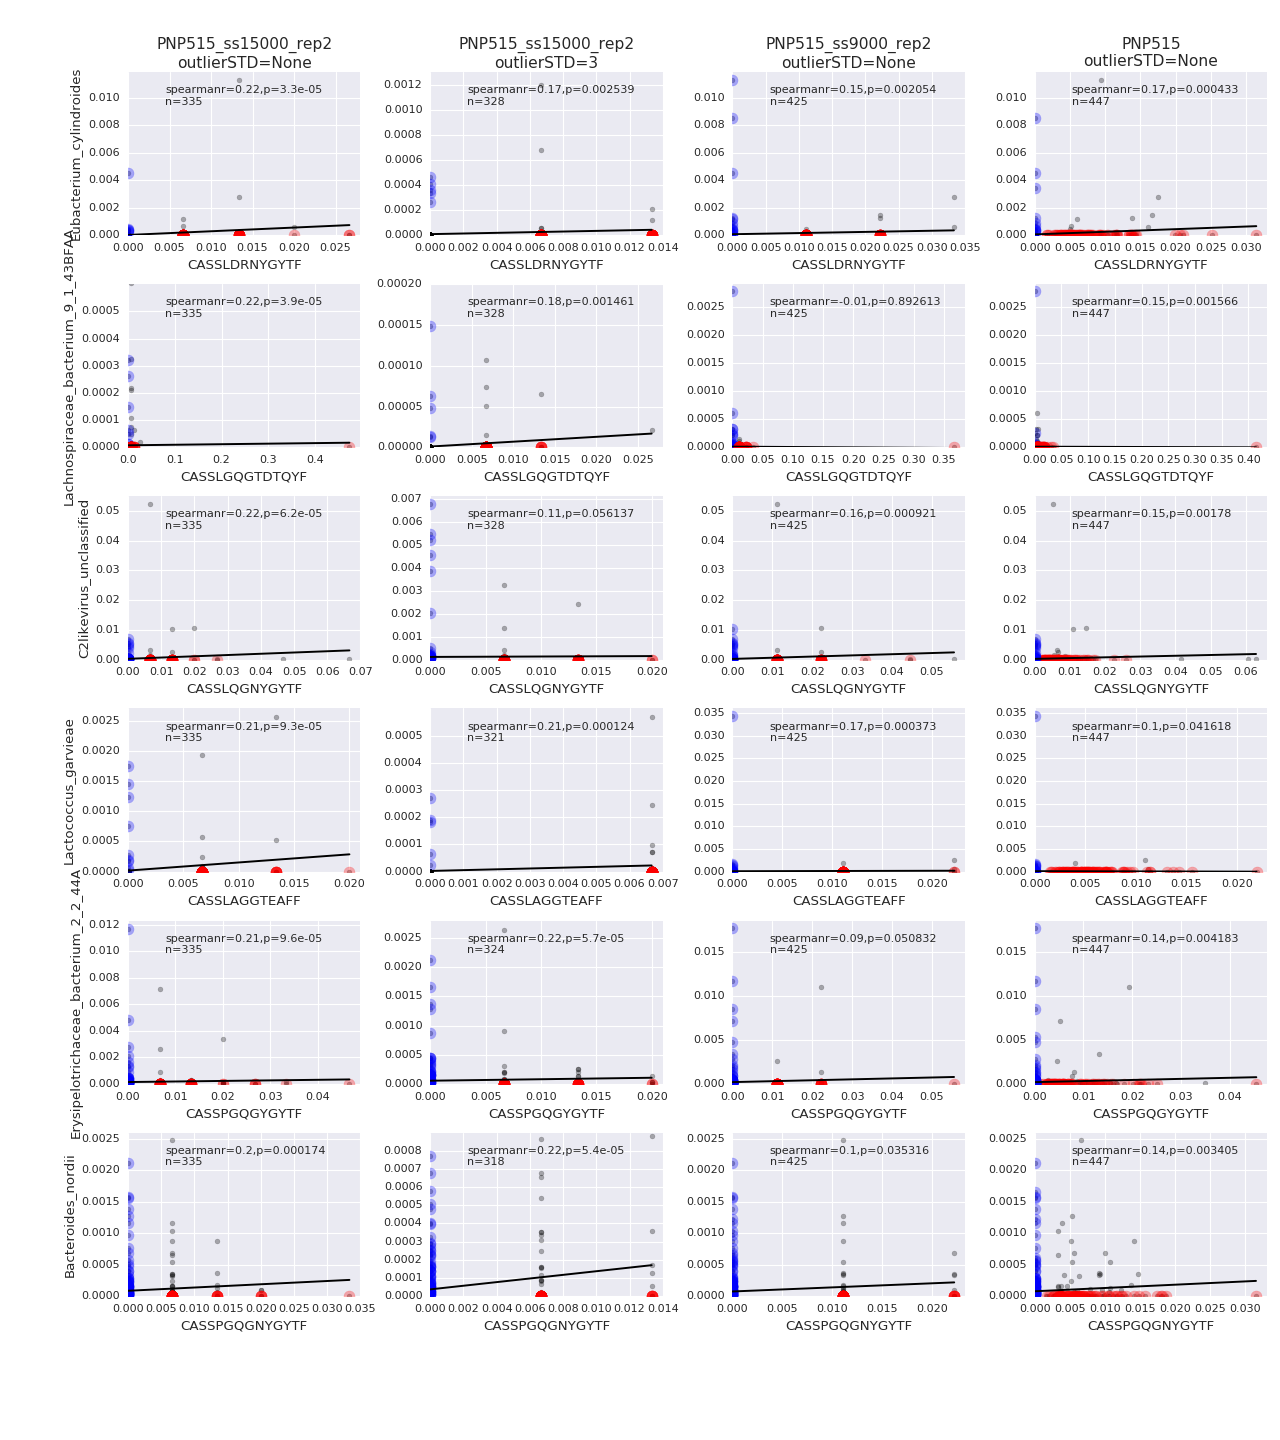

In [112]:
plt.show()

In [108]:
#sort by OR and not r:
topPositive2=merged_tests.sort_values(by=['log10OR_real','r_real'],ascending=False).head(6)
topPositive2

species             seq    r_real  nSamplesSeq  \
1096            Alistipes_shahii  CASSLGGSSYEQYF  0.147226           70   
1070     Roseburia_inulinivorans    CASSLGADTQYF  0.142289           51   
1003            Alistipes_shahii      CASSSYEQYF  0.135700           54   
844            Dorea_longicatena    CASSLVGYEQYF  0.118489           74   
895   Acidaminococcus_fermentans     CASSLSYEQYF  0.123666          142   
1119      Bilophila_unclassified     CASSLAETQYF  0.150145           59   

      nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
1096              318              70              0.007301   
1070              312              51              0.010301   
1003              318              54              0.014101   
844               322              74              0.029503   
895                 9               8              0.021302   
1119              292              58              0.006101   

      Sig by bonferroni corrected pVal_correlation  sig. by FDR=0.01  \
1096                                             0                 0   
1070                                             0                 0   
1003                                             0                 0   
844                                              0                 0   
895                                              0                 0   
1119                                             0                 0   

      sig. by FDR=0.1_correlation          ...             Reference_VDJDB  \
1096                            0          ...                         NaN   
1070                            0          ...                         NaN   
1003                            0          ...           ['PMID:28636592']   
844                             0          ...                         NaN   
895                             0          ...                         NaN   
1119                            0          ...                         NaN   

      Score_VDJDB  Species_CMVpaper  Epitope species_CMVpaper  \
1096          NaN               NaN                       NaN   
1070          NaN               NaN                       NaN   
1003       [1, 0]               NaN                       NaN   
844           NaN               NaN                       NaN   
895           NaN               NaN                       NaN   
1119          NaN               NaN                       NaN   

      Reference_CMVpaper  Score_CMVpaper  Species_McPAS  Category_McPAS  \
1096                 NaN             NaN      ['Human']      ['Cancer']   
1070                 NaN             NaN            NaN             NaN   
1003                 NaN             NaN      ['Mouse']   ['Pathogens']   
844                  NaN             NaN            NaN             NaN   
895                  NaN             NaN      ['Human']   ['Pathogens']   
1119                 NaN             NaN            NaN             NaN   

            Pathology_McPAS       PubMed.ID_McPAS  
1096  ['Colorectal cancer']            [23771160]  
1070                    NaN                   NaN  
1003          ['Influenza']  [25804828, 28636592]  
844                     NaN                   NaN  
895           ['Influenza']            [28636589]  
1119                    NaN                   NaN  

[6 rows x 32 columns]

In [109]:
color_binary=True
corrTest='spearman'

seqList=list(topPositive2['seq'])
speciesList=list(topPositive2['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=3
        else:
            outlierSTD=None
        ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,outlierSTD)
        if i==0:
            ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
        if j!=0:
            ax.set_ylabel('')

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)


             

##############
0 0 CASSLGGSSYEQYF Alistipes_shahii
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSLGGSSYEQYF Alistipes_shahii
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSLGGSSYEQYF Alistipes_shahii
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped

##############
5 0 CASSLAETQYF Bilophila_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 1 CASSLAETQYF Bilophila_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 2 CASSLAETQYF Bilophila_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to 

limit_output extension: Maximum message size of 10000 exceeded with 10024 characters

<IPython.core.display.Javascript object>


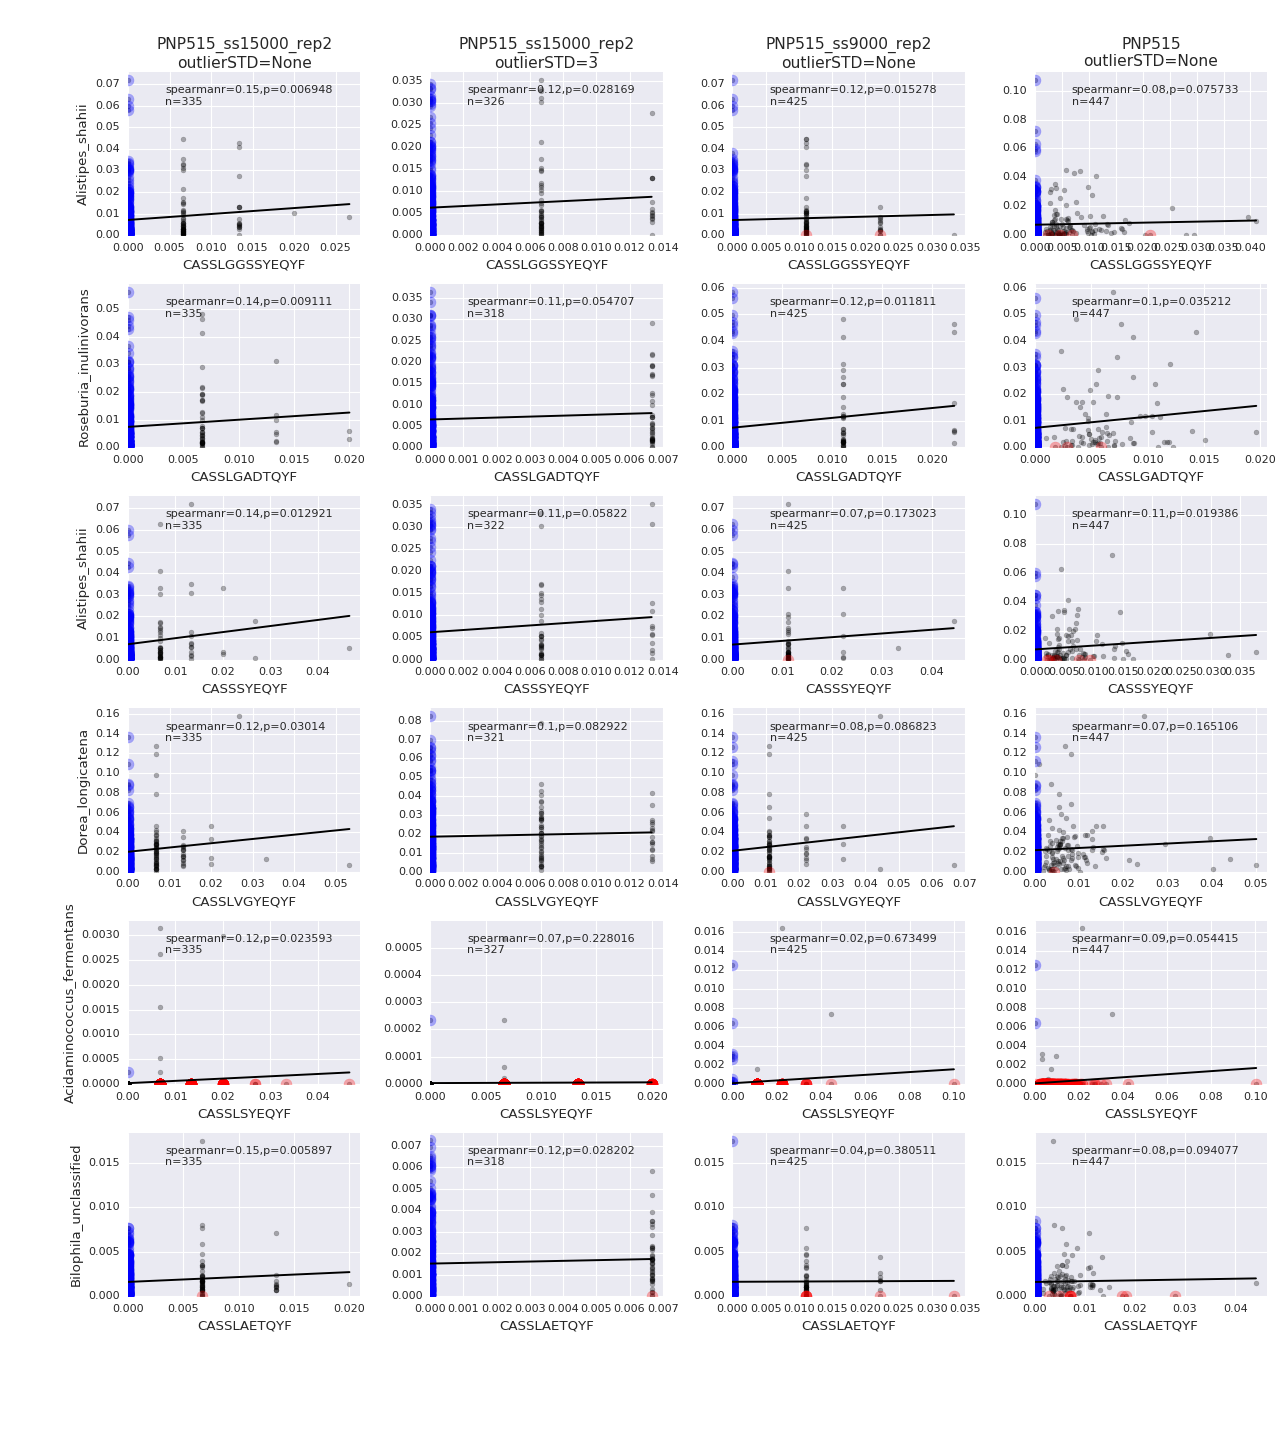

In [110]:
plt.show()

In [121]:
#sort by correlation p-value:
topPositive3=merged_tests[merged_tests['r_real']>0].sort_values(by=['real_p_Corr9998Perms','real_p_Fisher9999Perms']).head(6)
topPositive3

species              seq    r_real  \
1275                   Alistipes_putredinis      CASSLKETQYF  0.200318   
1273               Bacteroides_intestinalis     CASSLGAYEQYF  0.199070   
1283   Lachnospiraceae_bacterium_9_1_43BFAA   CASSLGQGTDTQYF  0.222659   
1284               Eubacterium_cylindroides    CASSLDRNYGYTF  0.224770   
1280  Erysipelotrichaceae_bacterium_2_2_44A    CASSPGQGYGYTF  0.211526   
1271                   Alistipes_putredinis  CASSELAGGPDTQYF  0.198203   

      nSamplesSeq  nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
1275           80              291              75                0.0001   
1273           60               96              29                0.0002   
1283           70               17              10                0.0002   
1284           69               15               9                0.0002   
1280           67               66              25                0.0003   
1271           98              291              93                0.0003   

      Sig by bonferroni corrected pVal_correlation  sig. by FDR=0.01  \
1275                                             0                 0   
1273                                             0                 0   
1283                                             0                 0   
1284                                             0                 0   
1280                                             0                 0   
1271                                             0                 0   

      sig. by FDR=0.1_correlation       ...           Reference_VDJDB  \
1275                            0       ...                       NaN   
1273                            0       ...         ['PMID:28636589']   
1283                            0       ...                       NaN   
1284                            0       ...                       NaN   
1280                            0       ...                       NaN   
1271                            0       ...                       NaN   

      Score_VDJDB  Species_CMVpaper  Epitope species_CMVpaper  \
1275          NaN               NaN                       NaN   
1273          [0]               NaN                       NaN   
1283          NaN               NaN                       NaN   
1284          NaN               NaN                       NaN   
1280          NaN               NaN                       NaN   
1271          NaN               NaN                       NaN   

      Reference_CMVpaper  Score_CMVpaper  Species_McPAS  Category_McPAS  \
1275                 NaN             NaN            NaN             NaN   
1273                 NaN             NaN      ['Human']   ['Pathogens']   
1283                 NaN             NaN      ['Human']   ['Pathogens']   
1284                 NaN             NaN            NaN             NaN   
1280                 NaN             NaN            NaN             NaN   
1271                 NaN             NaN            NaN             NaN   

                   Pathology_McPAS  PubMed.ID_McPAS  
1275                           NaN              NaN  
1273  ['Epstein Barr virus (EBV)']       [28636589]  
1283                 ['Influenza']       [28636589]  
1284                           NaN              NaN  
1280                           NaN              NaN  
1271                           NaN              NaN  

[6 rows x 32 columns]

In [125]:
color_binary=True
corrTest='spearman'

seqList=list(topPositive3['seq'])
speciesList=list(topPositive3['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=3
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)


             

##############
0 0 CASSLKETQYF Alistipes_putredinis
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSLKETQYF Alistipes_putredinis
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSLKETQYF Alistipes_putredinis
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrou

loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
3 UserIDs have more than one BD
groupedDF length before dropping same person samples is 450
removing UserIDs: [3290, 447, 2363]
removing BD: [u'BD714', u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 447_2
##############
5 0 CASSELAGGPDTQYF Alistipes_putredinis
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 1 CASSELAGGPDTQYF Alistipes_putredinis
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping

limit_output extension: Maximum message size of 10000 exceeded with 10220 characters

<IPython.core.display.Javascript object>


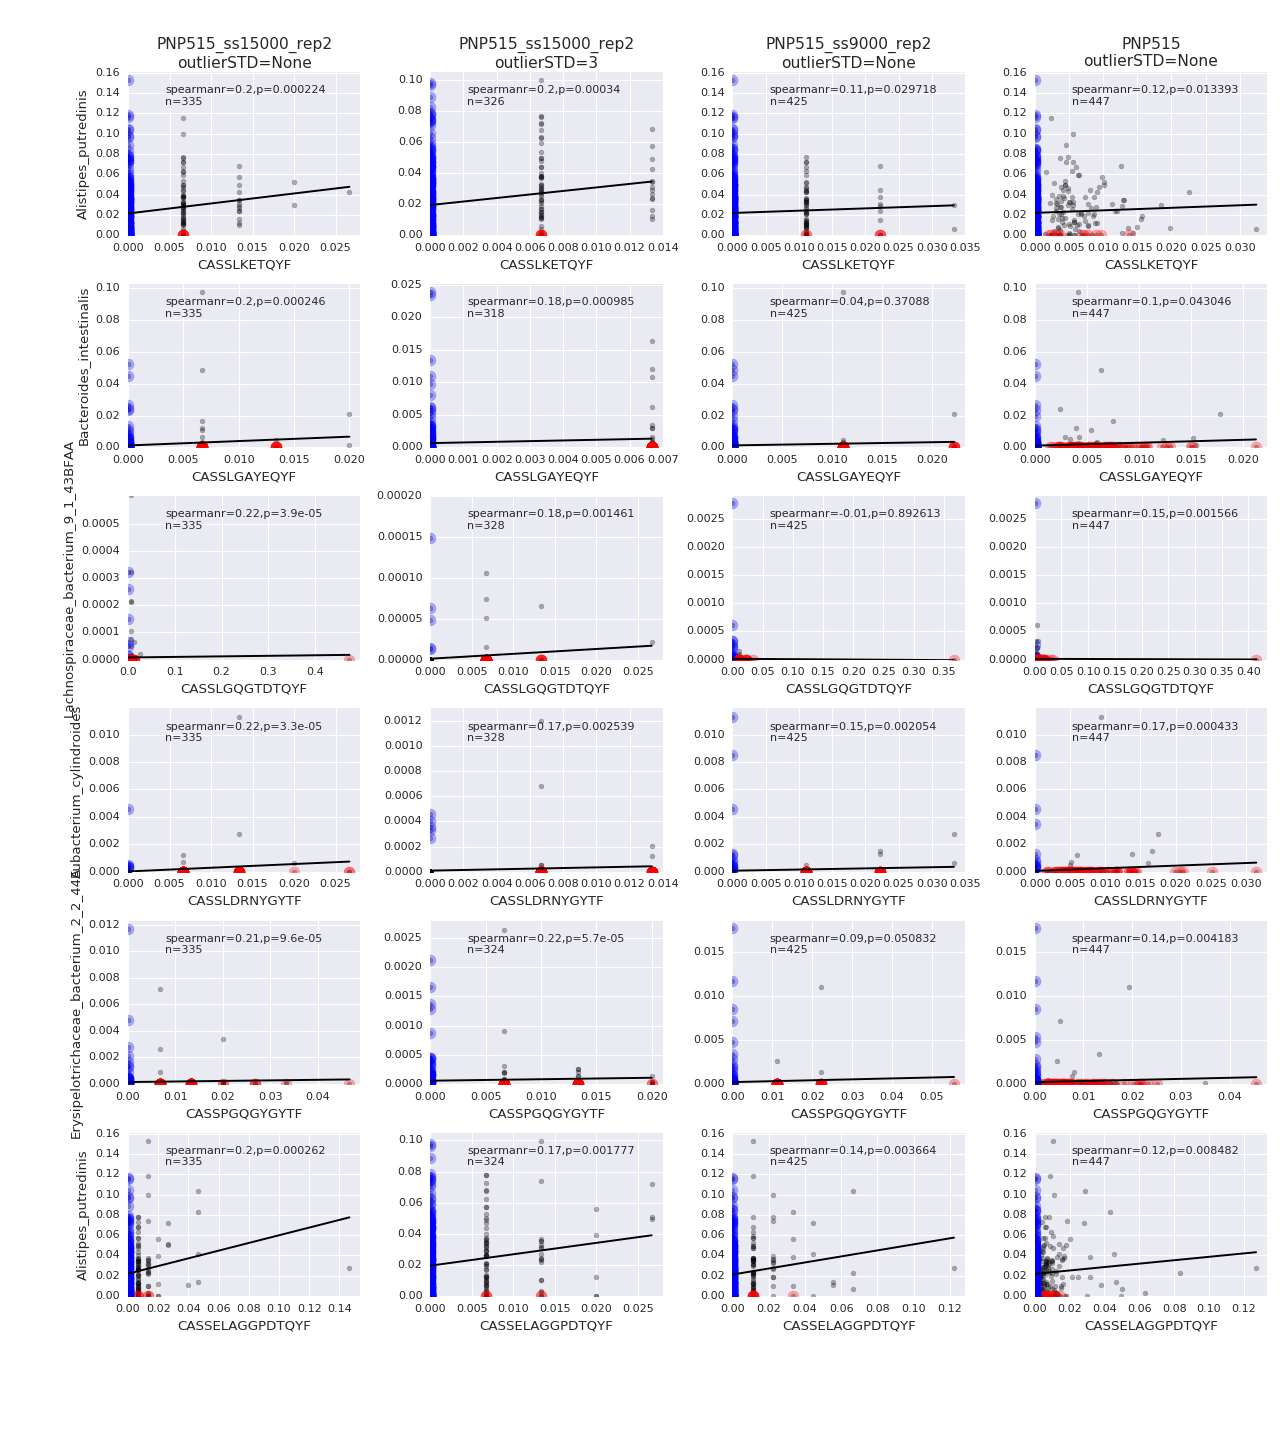

In [126]:
plt.show()

### high positive r, sig p, do not appear in fisher results since all samples have the species

In [116]:
spearman.head()

species             seq    r_real  \
12998                     Prevotella_copri    CASSLSGYEQYF -0.208157   
1007                    Eubacterium_hallii   CASSDRDTGELFF -0.206572   
11943              Akkermansia_muciniphila  CASSLGTGSYEQYF -0.197068   
18505  Lachnospiraceae_bacterium_8_1_57FAA   CASSLGGNTEAFF -0.196836   
16283             Escherichia_unclassified    CASSLGGTEAFF -0.194766   

       nSamplesSeq  nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
12998           50              220              24                0.0002   
1007           132              333             132                0.0002   
11943           57              227              28                0.0003   
18505          136              154              50                0.0005   
16283           91              176              33                0.0004   

       Sig by bonferroni corrected pVal  sig. by FDR=0.01  sig. by FDR=0.1  \
12998                                 0                 0                0   
1007                                  0                 0                0   
11943                                 0                 0                0   
18505                                 0                 0                0   
16283                                 0                 0                0   

       sig. by FDR=0.25  
12998                 0  
1007                  0  
11943                 0  
18505                 0  
16283                 0

In [127]:
spearman.columns.values

array([u'species', u'seq', u'r_real', u'nSamplesSeq', u'nSamplesSpecies',
       u'nComSeqSpecies', u'real_p_Corr9998Perms',
       u'Sig by bonferroni corrected pVal', u'sig. by FDR=0.01',
       u'sig. by FDR=0.1', u'sig. by FDR=0.25'], dtype=object)

In [131]:
topPositive4=spearman[(spearman['r_real']>0)&(spearman['nSamplesSpecies']==335)].sort_values(by=['real_p_Corr9998Perms']).head(6)
topPositive4

species            seq    r_real  nSamplesSeq  \
422  Subdoligranulum_unclassified  CASSLSGNTEAFF  0.166402           60   
473  Subdoligranulum_unclassified    CASSLRDTQYF  0.162796           55   
343  Subdoligranulum_unclassified    CASSFSYEQYF  0.150961           75   
146          Ruminococcus_torques  CASSLTVNTEAFF  0.151177           65   
131          Ruminococcus_torques  CASSVGGNTEAFF  0.147521           62   
393  Subdoligranulum_unclassified   CASSLGPYEQYF  0.147391           66   

     nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
422              335              60              0.002500   
473              335              55              0.002500   
343              335              75              0.003000   
146              335              65              0.005601   
131              335              62              0.006901   
393              335              66              0.007101   

     Sig by bonferroni corrected pVal  sig. by FDR=0.01  sig. by FDR=0.1  \
422                                 0                 0                0   
473                                 0                 0                0   
343                                 0                 0                0   
146                                 0                 0                0   
131                                 0                 0                0   
393                                 0                 0                0   

     sig. by FDR=0.25  
422                 0  
473                 0  
343                 0  
146                 0  
131                 0  
393                 0

In [132]:
color_binary=True
corrTest='spearman'

seqList=list(topPositive4['seq'])
speciesList=list(topPositive4['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=3
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)


             

##############
0 0 CASSLSGNTEAFF Subdoligranulum_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSLSGNTEAFF Subdoligranulum_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSLSGNTEAFF Subdoligranulum_unclassified
##############
loading most updated Mb file...
seq CASSLSGNTEAFF do not exist in dataset PNP515_ss90

##############
5 1 CASSLGPYEQYF Subdoligranulum_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 2 CASSLGPYEQYF Subdoligranulum_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
3 UserIDs have more than one BD
groupedDF length before dropping same person samples is 428
removing UserIDs: [3290, 447, 2363]
removing BD: [u'BD714', u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 425_2
##############
5 3 CASSLGPYEQYF Subdoligranulum_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID 

<IPython.core.display.Javascript object>


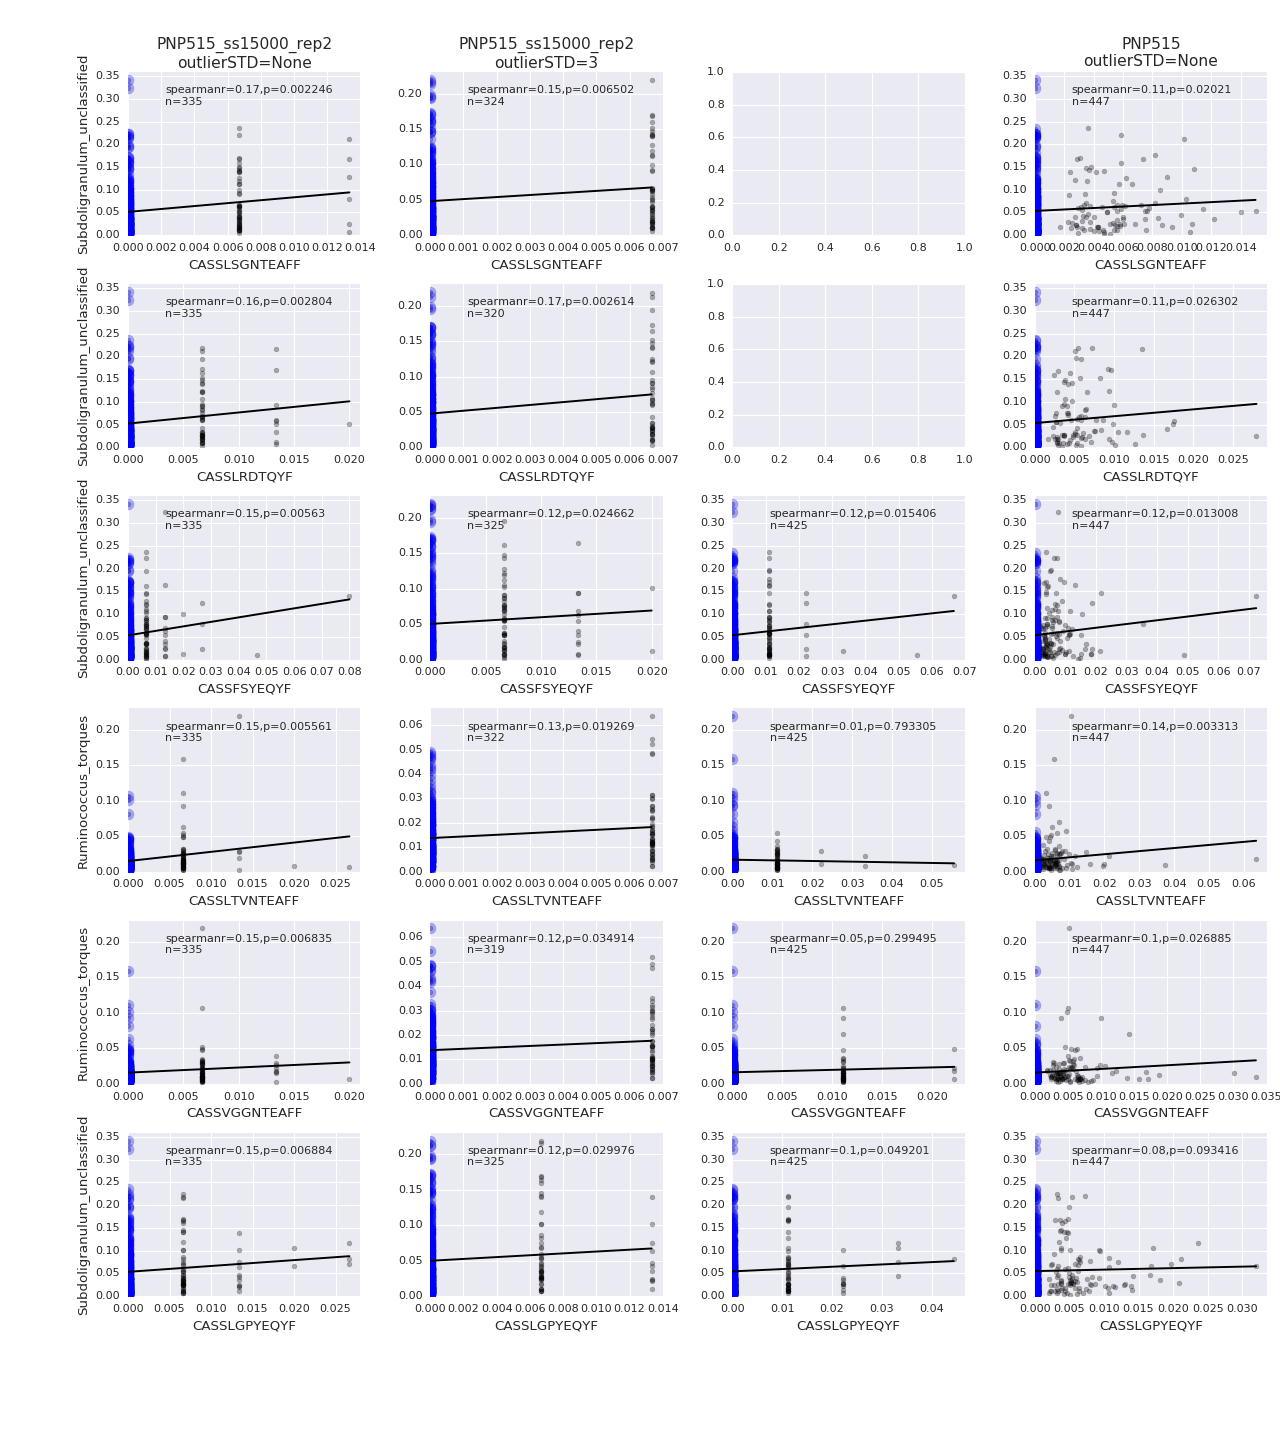

In [133]:
plt.show()

### almost all samples that have the sequence have the species - high positive log OR, not in the correlation

In [134]:
fisher.head()

species              seq  log10OR_real  \
31856                  Veillonella_atypica    CASSLSGANVLTF     -0.934689   
34158           Coprobacillus_unclassified      CASSYQETQYF     -1.117639   
19062                   Clostridium_leptum  CASSELAGGQETQYF     -0.453745   
15783             Escherichia_unclassified     CASSLGGTEAFF     -0.395929   
14496  Lachnospiraceae_bacterium_1_1_57FAA    CASSYRDTGELFF      0.563373   

       speciesNegSeqNeg  speciesNegSeqPos  speciesPosSeqNeg  speciesPosSeqPos  \
31856               212                64                57                 2   
34158               225                59                50                 1   
19062               141                65               111                18   
15783               101                58               143                33   
14496               138                11               144                42   

       real_p_Fisher9999Perms  Sig by bonferroni corrected pVal  \
31856                  0.0001                                 0   
34158                  0.0002                                 0   
19062                  0.0002                                 0   
15783                  0.0002                                 0   
14496                  0.0002                                 0   

       sig. by FDR=0.1  sig. by FDR=0.25  
31856                0                 0  
34158                0                 0  
19062                0                 0  
15783                0                 0  
14496                0                 0

In [135]:
fisher.columns.values

array([u'species', u'seq', u'log10OR_real', u'speciesNegSeqNeg',
       u'speciesNegSeqPos', u'speciesPosSeqNeg', u'speciesPosSeqPos',
       u'real_p_Fisher9999Perms', u'Sig by bonferroni corrected pVal',
       u'sig. by FDR=0.1', u'sig. by FDR=0.25'], dtype=object)

In [144]:
topPositive5=fisher[(fisher['log10OR_real'].astype('str')!='inf')&(fisher['real_p_Fisher9999Perms']<0.001)].sort_values(by='log10OR_real',ascending=False).head(6)
topPositive5

species             seq  log10OR_real  \
7800                    Bacteroides_caccae    CASSPGGYEQYF      0.635422   
14496  Lachnospiraceae_bacterium_1_1_57FAA   CASSYRDTGELFF      0.563373   
11322              Akkermansia_muciniphila  CSARLAGGQETQYF      0.439718   
13084               Alistipes_indistinctus     CASSLKETQYF      0.410193   
16310               Bacteroides_salyersiae   CASSLTGNTEAFF      0.372689   
15783             Escherichia_unclassified    CASSLGGTEAFF     -0.395929   

       speciesNegSeqNeg  speciesNegSeqPos  speciesPosSeqNeg  speciesPosSeqPos  \
7800                 51                 5               196                83   
14496               138                11               144                42   
11322                94                14               161                66   
13084               109                18               146                62   
16310               139                30               110                56   
15783               101                58               143                33   

       real_p_Fisher9999Perms  Sig by bonferroni corrected pVal  \
7800                   0.0006                                 0   
14496                  0.0002                                 0   
11322                  0.0006                                 0   
13084                  0.0008                                 0   
16310                  0.0006                                 0   
15783                  0.0002                                 0   

       sig. by FDR=0.1  sig. by FDR=0.25  
7800                 0                 0  
14496                0                 0  
11322                0                 0  
13084                0                 0  
16310                0                 0  
15783                0                 0

In [145]:
color_binary=True
corrTest='spearman'

seqList=list(topPositive5['seq'])
speciesList=list(topPositive5['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=3
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)


             

##############
0 0 CASSPGGYEQYF Bacteroides_caccae
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSPGGYEQYF Bacteroides_caccae
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSPGGYEQYF Bacteroides_caccae
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped

##############
5 0 CASSLGGTEAFF Escherichia_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 1 CASSLGGTEAFF Escherichia_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 2 CASSLGGTEAFF Escherichia_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID

limit_output extension: Maximum message size of 10000 exceeded with 10140 characters

<IPython.core.display.Javascript object>


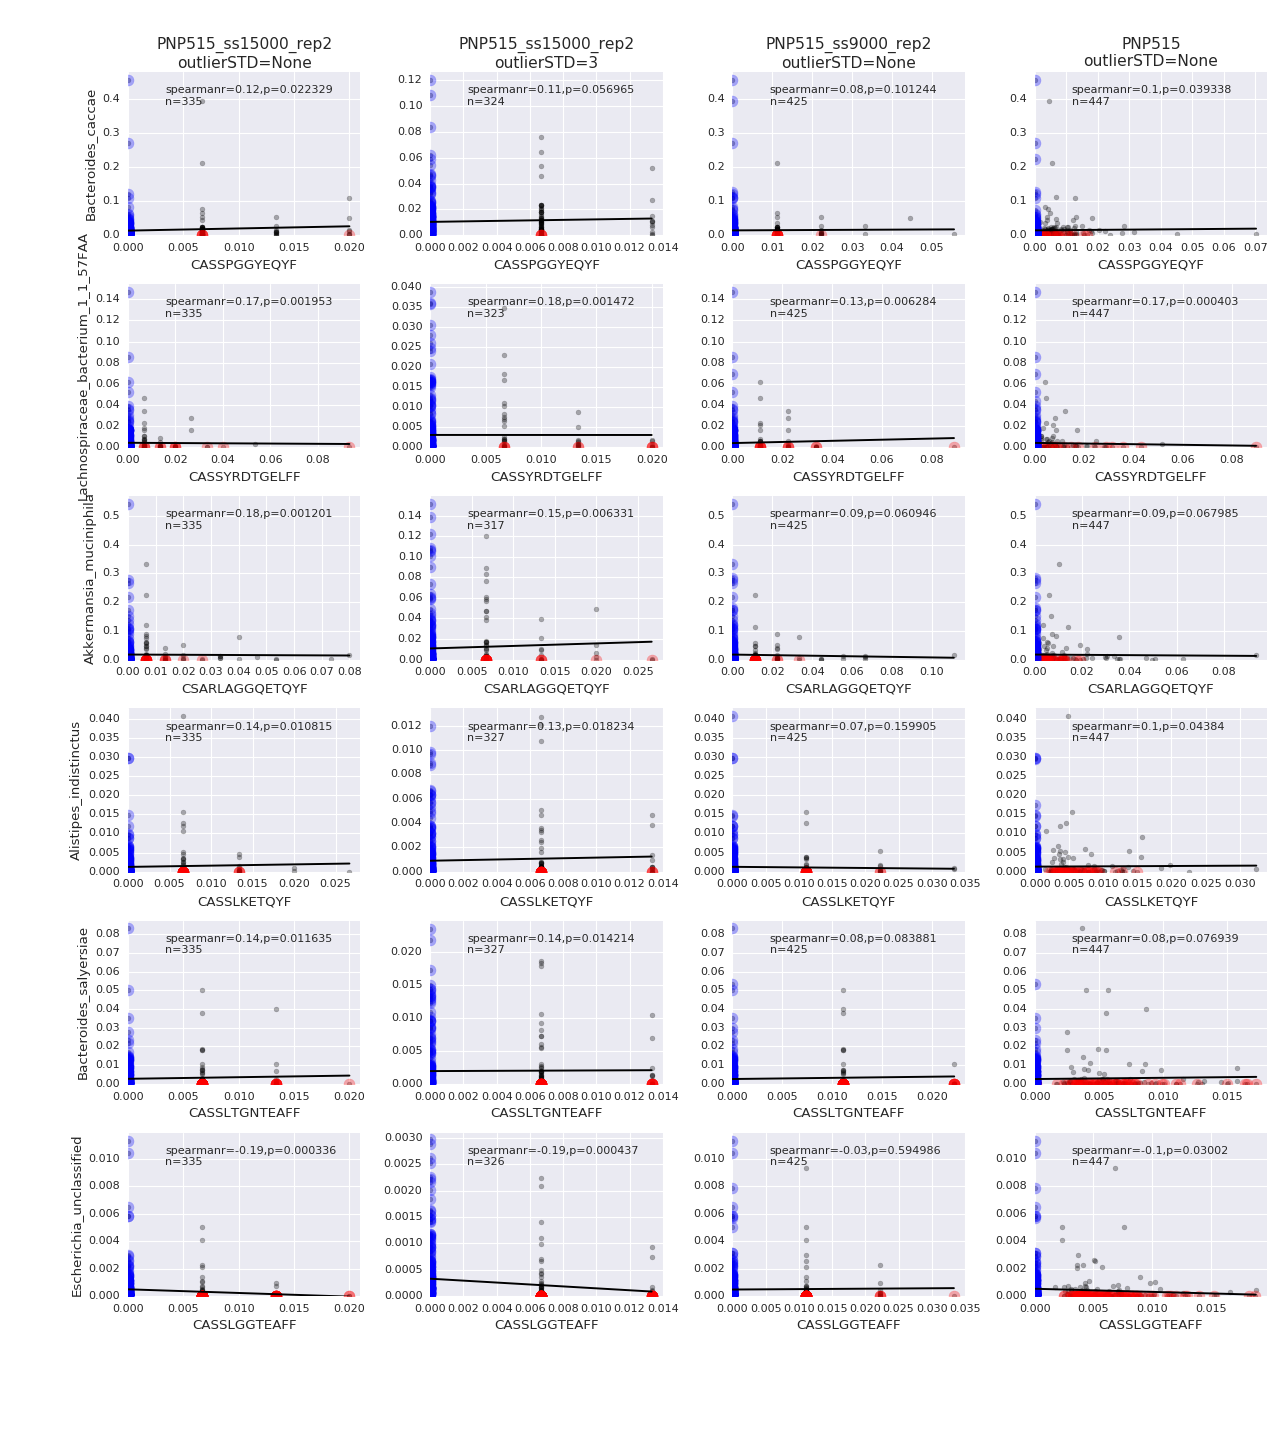

In [146]:
plt.show()

### r>0.2, p<0.005

In [214]:
topPositive6=merged_tests[(merged_tests['r_real']>=0.2)&(merged_tests['real_p_Corr9998Perms']<0.005)].sort_values(by=['r_real','log10OR_real'],ascending=False).head(6)
topPositive6

species             seq    r_real  \
1284               Eubacterium_cylindroides   CASSLDRNYGYTF  0.224770   
1283   Lachnospiraceae_bacterium_9_1_43BFAA  CASSLGQGTDTQYF  0.222659   
1282               C2likevirus_unclassified   CASSLQGNYGYTF  0.217009   
1281                   Lactococcus_garvieae   CASSLAGGTEAFF  0.211890   
1280  Erysipelotrichaceae_bacterium_2_2_44A   CASSPGQGYGYTF  0.211526   
1279                     Bacteroides_nordii  CASSPGQGNYGYTF  0.203710   

      nSamplesSeq  nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
1284           69               15               9                0.0002   
1283           70               17              10                0.0002   
1282           61               37              15                0.0004   
1281           57               18               9                0.0006   
1280           67               66              25                0.0003   
1279           67               95              31                0.0004   

      Sig by bonferroni corrected pVal_correlation  sig. by FDR=0.01  \
1284                                             0                 0   
1283                                             0                 0   
1282                                             0                 0   
1281                                             0                 0   
1280                                             0                 0   
1279                                             0                 0   

      sig. by FDR=0.1_correlation       ...           Reference_VDJDB  \
1284                            0       ...                       NaN   
1283                            0       ...                       NaN   
1282                            0       ...         ['PMID:28636589']   
1281                            0       ...                       NaN   
1280                            0       ...                       NaN   
1279                            0       ...                       NaN   

      Score_VDJDB  Species_CMVpaper  Epitope species_CMVpaper  \
1284          NaN               NaN                       NaN   
1283          NaN               NaN                       NaN   
1282          [0]               NaN                       NaN   
1281          NaN               NaN                       NaN   
1280          NaN               NaN                       NaN   
1279          NaN               NaN                       NaN   

      Reference_CMVpaper  Score_CMVpaper  Species_McPAS  Category_McPAS  \
1284                 NaN             NaN            NaN             NaN   
1283                 NaN             NaN      ['Human']   ['Pathogens']   
1282                 NaN             NaN      ['Human']   ['Pathogens']   
1281                 NaN             NaN            NaN             NaN   
1280                 NaN             NaN            NaN             NaN   
1279                 NaN             NaN            NaN             NaN   

      Pathology_McPAS  PubMed.ID_McPAS  
1284              NaN              NaN  
1283    ['Influenza']       [28636589]  
1282    ['Influenza']       [28636589]  
1281              NaN              NaN  
1280              NaN              NaN  
1279              NaN              NaN  

[6 rows x 32 columns]

In [229]:
topPositive6.iloc[:,-12:]

Species_VDJDB Epitope species_VDJDB    Reference_VDJDB Score_VDJDB  \
1284              NaN                   NaN                NaN         NaN   
1283              NaN                   NaN                NaN         NaN   
1282  ['HomoSapiens']        ['InfluenzaA']  ['PMID:28636589']         [0]   
1281              NaN                   NaN                NaN         NaN   
1280              NaN                   NaN                NaN         NaN   
1279              NaN                   NaN                NaN         NaN   

      Species_CMVpaper  Epitope species_CMVpaper  Reference_CMVpaper  \
1284               NaN                       NaN                 NaN   
1283               NaN                       NaN                 NaN   
1282               NaN                       NaN                 NaN   
1281               NaN                       NaN                 NaN   
1280               NaN                       NaN                 NaN   
1279               NaN                       NaN                 NaN   

      Score_CMVpaper Species_McPAS Category_McPAS Pathology_McPAS  \
1284             NaN           NaN            NaN             NaN   
1283             NaN     ['Human']  ['Pathogens']   ['Influenza']   
1282             NaN     ['Human']  ['Pathogens']   ['Influenza']   
1281             NaN           NaN            NaN             NaN   
1280             NaN           NaN            NaN             NaN   
1279             NaN           NaN            NaN             NaN   

     PubMed.ID_McPAS  
1284             NaN  
1283      [28636589]  
1282      [28636589]  
1281             NaN  
1280             NaN  
1279             NaN

In [215]:
dfName='topPositive6'
color_binary=True
corrTest='spearman'

seqList=list(topPositive6['seq'])
speciesList=list(topPositive6['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                    '%s/TCR_real_data/SubSampled15000data_rep1' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss15000_rep1','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        if j==2:
            onlyNextera=True
        else:
            onlyNextera=False 
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=5
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,onlyNextera,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
                if j==2:
                    ax.set_title('%s\noutlierSTD=%s\nOnly Nextera samples!' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)

figFolder='%s/TCR_real_data/seqSpeciesPairImages' %MyPath
if not isdir(figFolder):
    makedirs(figFolder)
figFile='%s/%s' %(figFolder,dfName)
fig.savefig(figFile,dpi=200)


             

##############
0 0 CASSLDRNYGYTF Eubacterium_cylindroides
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSLDRNYGYTF Eubacterium_cylindroides
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSLDRNYGYTF Eubacterium_cylindroides
##############
loading most updated Mb file...filtered

loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
3 UserIDs have more than one BD
groupedDF length before dropping same person samples is 428
removing UserIDs: [3290, 447, 2363]
removing BD: [u'BD714', u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 425_2
##############
3 4 CASSLAGGTEAFF Lactococcus_garvieae
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
3 UserIDs have more than one BD
groupedDF length before dropping same person samples is 450
removing UserIDs: [3290, 447, 2363]
removing BD: [u'BD714', u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 447_2
##############
4 0 CASSPGQGYGYTF Erysipelotrichaceae_bacterium_2_2_44A
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID in

limit_output extension: Maximum message size of 10000 exceeded with 10034 characters

### only nextera data:

In [216]:
merged_nextera.head()

species          seq    r_real  nSamplesSeq  nSamplesSpecies  \
0  Ruminococcus_torques  CASSLGETQYF  0.071143        103.0            178.0   
0  Ruminococcus_torques  CASSLSYEQYF -0.078432         79.0            178.0   
0  Ruminococcus_torques  CASSLGYEQYF  0.053485         94.0            178.0   
0  Ruminococcus_torques  CASSSSYEQYF -0.027185         83.0            178.0   
0  Ruminococcus_torques  CASSLQETQYF -0.031081         77.0            178.0   

   nComSeqSpecies  
0           103.0  
0            79.0  
0            94.0  
0            83.0  
0            77.0

In [217]:
topPositive7=merged_nextera[merged_nextera['r_real']>=0.3].sort_values(by='r_real',ascending=False).head(6)
topPositive7

species            seq    r_real  nSamplesSeq  \
0                      Blautia_producta   CASSQGNYGYTF  0.356203         25.0   
0  Lachnospiraceae_bacterium_9_1_43BFAA   CASSQGNYGYTF  0.336332         25.0   
0        Orthohepadnavirus_unclassified  CASSLRGNTEAFF  0.332381         34.0   
0                 Clostridium_symbiosum  CASSLGGTYEQYF  0.325909         30.0   
0               Streptococcus_australis  CASSLGQGYGYTF  0.322723         45.0   
0                 Gardnerella_vaginalis   CASSLSSYEQYF  0.321026         46.0   

   nSamplesSpecies  nComSeqSpecies  
0              9.0             6.0  
0             10.0             6.0  
0              4.0             4.0  
0             22.0            11.0  
0             49.0            23.0  
0              5.0             5.0

In [218]:
dfName='topPositive7'
color_binary=True
corrTest='spearman'

seqList=list(topPositive7['seq'])
speciesList=list(topPositive7['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                    '%s/TCR_real_data/SubSampled15000data_rep1' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss15000_rep1','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        if j==2:
            onlyNextera=True
        else:
            onlyNextera=False 
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=5
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,onlyNextera,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
                if j==2:
                    ax.set_title('%s\noutlierSTD=%s\nOnly Nextera samples!' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)

figFolder='%s/TCR_real_data/seqSpeciesPairImages' %MyPath
if not isdir(figFolder):
    makedirs(figFolder)
figFile='%s/%s' %(figFolder,dfName)
fig.savefig(figFile,dpi=200)


             

##############
0 0 CASSQGNYGYTF Blautia_producta
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSQGNYGYTF Blautia_producta
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSQGNYGYTF Blautia_producta
##############
loading most updated Mb file...filtered by libPrepMethod
loading B

loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
4 1 CASSLGQGYGYTF Streptococcus_australis
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
4 2 CASSLGQGYGYTF Streptococcus_australis
##############
loading most updated Mb file...filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
1 UserIDs have more than

limit_output extension: Maximum message size of 10000 exceeded with 10062 characters

## Negative relationships between species and sequences:

1. sig p-value in both tests, high  negative r, high negative log OR
2. high negative r, sig p, do not appear in fisher results since all samples have the species
3. almost all samples that have the sequence have the species - high negative log OR, not in the correlation

### sig p-value in both tests, high  negative r, high negative log OR

In [147]:
#sort by correlation r:
topNegative1=merged_tests.sort_values(by=['r_real','log10OR_real']).head(6)
topNegative1

species             seq    r_real  nSamplesSeq  \
0                     Prevotella_copri    CASSLSGYEQYF -0.208157           50   
1              Akkermansia_muciniphila  CASSLGTGSYEQYF -0.197068           57   
2  Lachnospiraceae_bacterium_8_1_57FAA   CASSLGGNTEAFF -0.196836          136   
3             Escherichia_unclassified    CASSLGGTEAFF -0.194766           91   
4                  Veillonella_atypica   CASSLSGANVLTF -0.191441           66   
5               Bacteroides_salyersiae   CASSLDSYNEQFF -0.190959           63   

   nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
0              220              24                0.0002   
1              227              28                0.0003   
2              154              50                0.0005   
3              176              33                0.0004   
4               59               2                0.0005   
5              166              20                0.0009   

   Sig by bonferroni corrected pVal_correlation  sig. by FDR=0.01  \
0                                             0                 0   
1                                             0                 0   
2                                             0                 0   
3                                             0                 0   
4                                             0                 0   
5                                             0                 0   

   sig. by FDR=0.1_correlation               ...                \
0                            0               ...                 
1                            0               ...                 
2                            0               ...                 
3                            0               ...                 
4                            0               ...                 
5                            0               ...                 

     Reference_VDJDB  Score_VDJDB  Species_CMVpaper  Epitope species_CMVpaper  \
0  ['PMID:28636592']          [0]               NaN                       NaN   
1                NaN          NaN               NaN                       NaN   
2                NaN          NaN               NaN                       NaN   
3  ['PMID:28423320']          [0]               NaN                       NaN   
4                NaN          NaN               NaN                       NaN   
5                NaN          NaN               NaN                       NaN   

   Reference_CMVpaper  Score_CMVpaper  Species_McPAS  \
0                 NaN             NaN      ['Mouse']   
1                 NaN             NaN            NaN   
2                 NaN             NaN      ['Human']   
3                 NaN             NaN      ['Human']   
4                 NaN             NaN            NaN   
5                 NaN             NaN      ['Human']   

                Category_McPAS  \
0                ['Pathogens']   
1                          NaN   
2               ['Autoimmune']   
3  ['Pathogens', 'Autoimmune']   
4                          NaN   
5                ['Pathogens']   

                                     Pathology_McPAS  \
0                                      ['Influenza']   
1                                                NaN   
2                                 ['Celiac disease']   
3  ['Influenza', 'Celiac disease', 'Diabetes Type...   
4                                                NaN   
5                                      ['Influenza']   

                  PubMed.ID_McPAS  
0            [25804828, 28636592]  
1                             NaN  
2                      [29269859]  
3  [28636589, 29269859, 27942583]  
4                             NaN  
5                      [28636589]  

[6 rows x 32 columns]

In [102]:
plt.ioff()

In [150]:
color_binary=True
corrTest='spearman'

seqList=list(topNegative1['seq'])
speciesList=list(topNegative1['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=3
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)


             

##############
0 0 CASSLSGYEQYF Prevotella_copri
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSLSGYEQYF Prevotella_copri
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSLSGYEQYF Prevotella_copri
##############
loading most updated Mb file...
seq CASSLSGYEQYF do not exist in dataset PNP515_ss9000_rep2
##############
0 3 CASSLSGYEQYF 

loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 1 CASSLDSYNEQFF Bacteroides_salyersiae
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 2 CASSLDSYNEQFF Bacteroides_salyersiae
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
3 UserIDs have more than one BD
groupedDF length before dropping same person sam

<IPython.core.display.Javascript object>


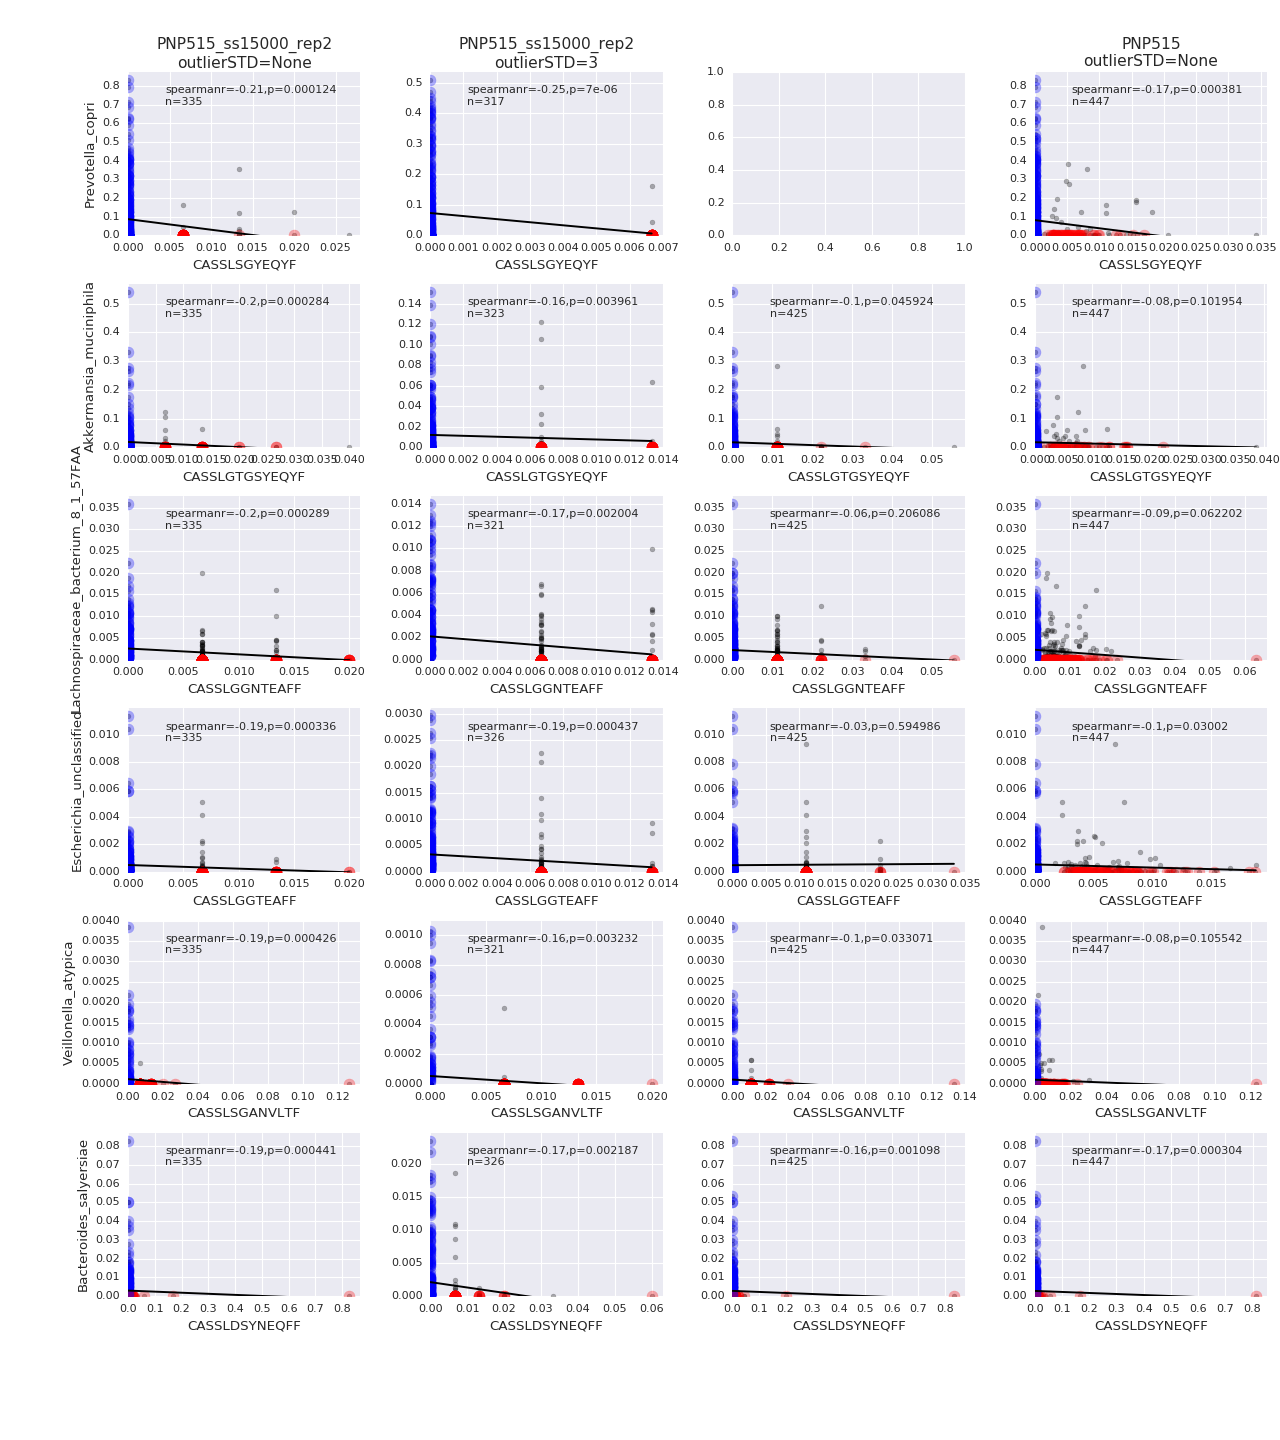

In [151]:
plt.show()

In [152]:
#sort by OR and not r:
topNegative2=merged_tests.sort_values(by=['log10OR_real','r_real']).head(6)
topNegative2

species            seq    r_real  nSamplesSeq  \
51   Ruminococcus_champanellensis  CASSLGGTDTQYF -0.157027           99   
70              Weissella_cibaria    CASSFSYEQYF -0.151391           75   
105     Acidaminococcus_intestini  CASSLSGNTEAFF -0.143348           60   
130         Enterococcus_faecalis   CASSLGPYEQYF -0.139890           66   
147          Citrobacter_freundii   CSARQGDTEAFF -0.137719           58   
151        Streptococcus_gordonii   CASSSSSYEQYF -0.136679           77   

     nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
51                19               0              0.004000   
70                25               0              0.005701   
105               29               0              0.008201   
130               25               0              0.013301   
147               28               0              0.013401   
151               20               0              0.014201   

     Sig by bonferroni corrected pVal_correlation  sig. by FDR=0.01  \
51                                              0                 0   
70                                              0                 0   
105                                             0                 0   
130                                             0                 0   
147                                             0                 0   
151                                             0                 0   

     sig. by FDR=0.1_correlation          ...             Reference_VDJDB  \
51                             0          ...                         NaN   
70                             0          ...                         NaN   
105                            0          ...                         NaN   
130                            0          ...                         NaN   
147                            0          ...           ['PMID:28423320']   
151                            0          ...                         NaN   

     Score_VDJDB  Species_CMVpaper  Epitope species_CMVpaper  \
51           NaN               NaN                       NaN   
70           NaN               NaN                       NaN   
105          NaN               NaN                       NaN   
130          NaN               NaN                       NaN   
147          [0]               NaN                       NaN   
151          NaN               NaN                       NaN   

     Reference_CMVpaper  Score_CMVpaper       Species_McPAS  \
51                  NaN             NaN                 NaN   
70                  NaN             NaN  ['Mouse', 'Human']   
105                 NaN             NaN                 NaN   
130                 NaN             NaN           ['Human']   
147                 NaN             NaN                 NaN   
151                 NaN             NaN                 NaN   

                  Category_McPAS                  Pathology_McPAS  \
51                           NaN                              NaN   
70   ['Pathogens', 'Autoimmune']  ['Influenza', 'Celiac disease']   
105                          NaN                              NaN   
130                ['Pathogens']                    ['Influenza']   
147                          NaN                              NaN   
151                          NaN                              NaN   

          PubMed.ID_McPAS  
51                    NaN  
70   [25804828, 29269859]  
105                   NaN  
130            [28636589]  
147                   NaN  
151                   NaN  

[6 rows x 32 columns]

In [153]:
color_binary=True
corrTest='spearman'

seqList=list(topNegative2['seq'])
speciesList=list(topNegative2['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=3
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)


             

##############
0 0 CASSLGGTDTQYF Ruminococcus_champanellensis
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSLGGTDTQYF Ruminococcus_champanellensis
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSLGGTDTQYF Ruminococcus_champanellensis
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099

loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 1 CASSSSSYEQYF Streptococcus_gordonii
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 2 CASSSSSYEQYF Streptococcus_gordonii
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
3 UserIDs have more than one BD
groupedDF length before dropping same person sampl

<IPython.core.display.Javascript object>


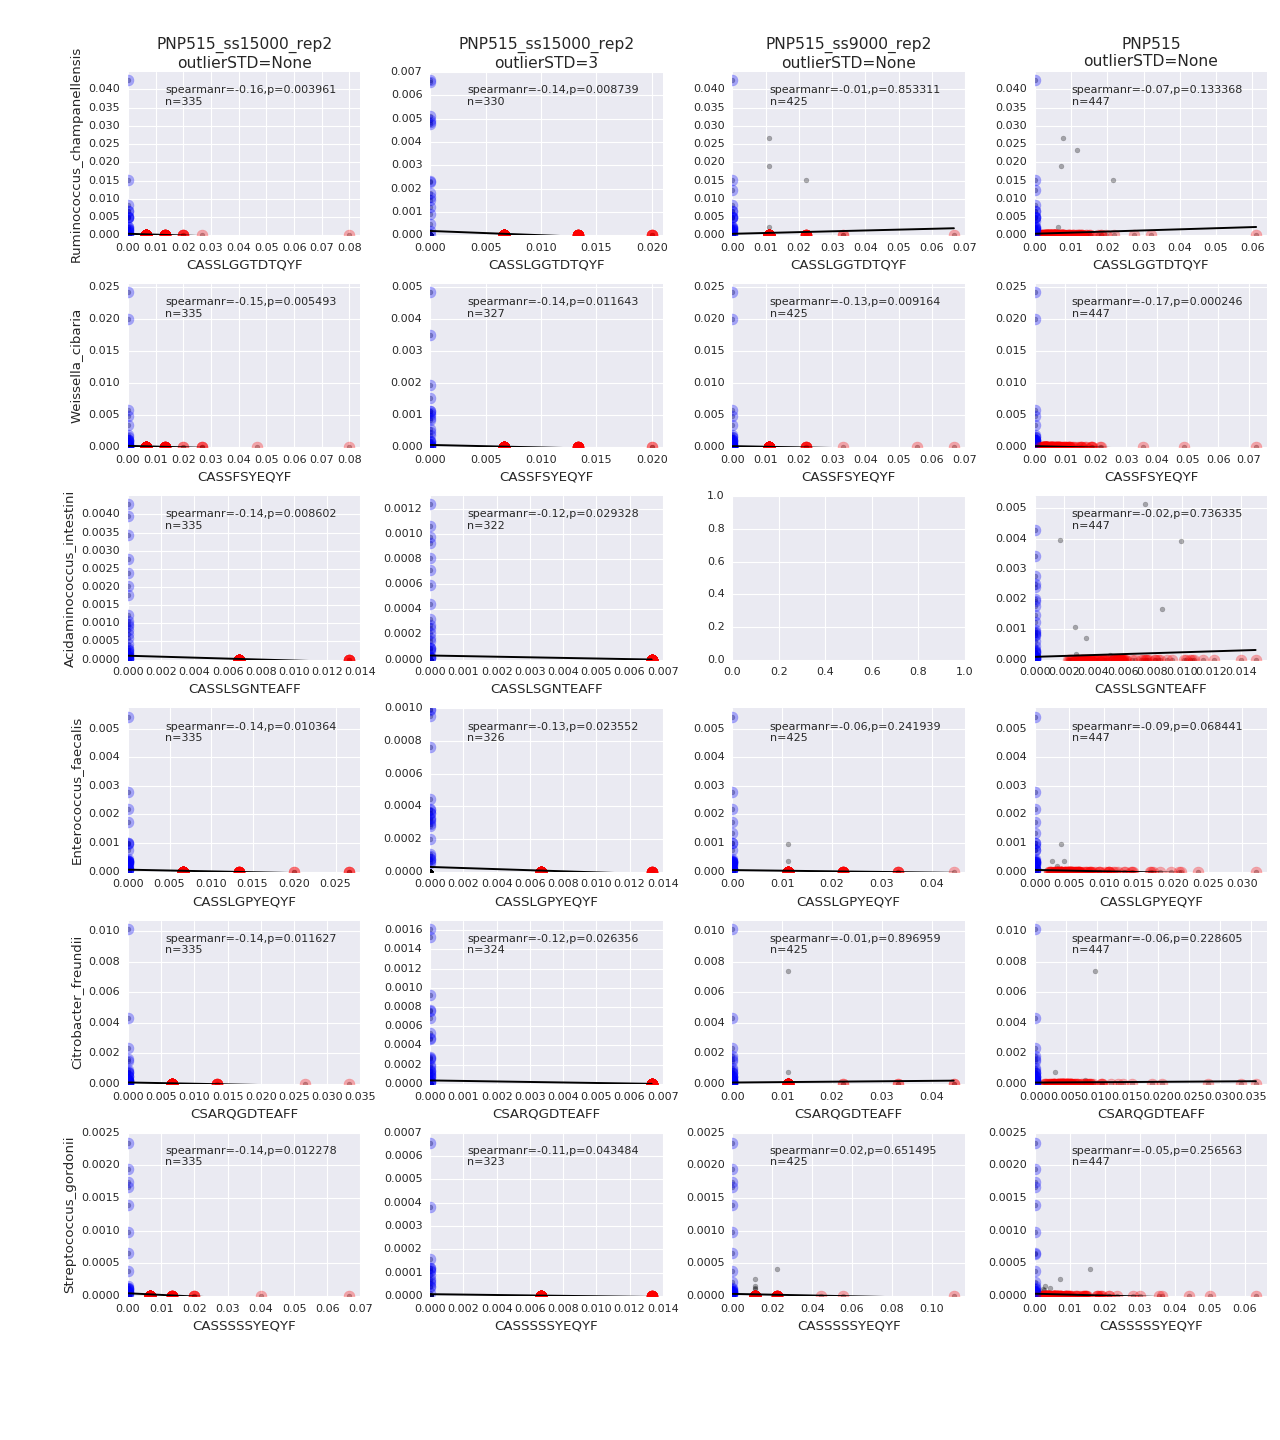

In [154]:
plt.show()

In [156]:
#sort by correlation p-value:
topNegative3=merged_tests[merged_tests['r_real']<0].sort_values(by=['real_p_Corr9998Perms','real_p_Fisher9999Perms']).head(6)
topNegative3

species              seq    r_real  \
0                     Prevotella_copri     CASSLSGYEQYF -0.208157   
1              Akkermansia_muciniphila   CASSLGTGSYEQYF -0.197068   
3             Escherichia_unclassified     CASSLGGTEAFF -0.194766   
6                   Clostridium_leptum  CASSELAGGQETQYF -0.190472   
4                  Veillonella_atypica    CASSLSGANVLTF -0.191441   
2  Lachnospiraceae_bacterium_8_1_57FAA    CASSLGGNTEAFF -0.196836   

   nSamplesSeq  nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
0           50              220              24                0.0002   
1           57              227              28                0.0003   
3           91              176              33                0.0004   
6           83              129              18                0.0004   
4           66               59               2                0.0005   
2          136              154              50                0.0005   

   Sig by bonferroni corrected pVal_correlation  sig. by FDR=0.01  \
0                                             0                 0   
1                                             0                 0   
3                                             0                 0   
6                                             0                 0   
4                                             0                 0   
2                                             0                 0   

   sig. by FDR=0.1_correlation               ...                \
0                            0               ...                 
1                            0               ...                 
3                            0               ...                 
6                            0               ...                 
4                            0               ...                 
2                            0               ...                 

                                     Reference_VDJDB  Score_VDJDB  \
0                                  ['PMID:28636592']          [0]   
1                                                NaN          NaN   
3                                  ['PMID:28423320']          [0]   
6  ['https://github.com/antigenomics/vdjdb-db/iss...          [0]   
4                                                NaN          NaN   
2                                                NaN          NaN   

   Species_CMVpaper  Epitope species_CMVpaper  Reference_CMVpaper  \
0               NaN                       NaN                 NaN   
1               NaN                       NaN                 NaN   
3               NaN                       NaN                 NaN   
6               NaN                       NaN                 NaN   
4               NaN                       NaN                 NaN   
2               NaN                       NaN                 NaN   

   Score_CMVpaper  Species_McPAS               Category_McPAS  \
0             NaN      ['Mouse']                ['Pathogens']   
1             NaN            NaN                          NaN   
3             NaN      ['Human']  ['Pathogens', 'Autoimmune']   
6             NaN      ['Human']                   ['Cancer']   
4             NaN            NaN                          NaN   
2             NaN      ['Human']               ['Autoimmune']   

                                     Pathology_McPAS  \
0                                      ['Influenza']   
1                                                NaN   
3  ['Influenza', 'Celiac disease', 'Diabetes Type...   
6                              ['Colorectal cancer']   
4                                                NaN   
2                                 ['Celiac disease']   

                  PubMed.ID_McPAS  
0            [25804828, 28636592]  
1                             NaN  
3  [28636589, 29269859, 27942583]  
6                      [23771160]  
4                             NaN  
2                      [29269859]  

[6 rows x 32 colum

In [160]:
color_binary=True
corrTest='spearman'

seqList=list(topNegative3['seq'])
speciesList=list(topNegative3['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=3
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)


             

##############
0 0 CASSLSGYEQYF Prevotella_copri
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSLSGYEQYF Prevotella_copri
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSLSGYEQYF Prevotella_copri
##############
loading most updated Mb file...
seq CASSLSGYEQYF do not exist in dataset PNP515_ss9000_rep2
##############
0 3 CASSLSGYEQYF 

loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 1 CASSLGGNTEAFF Lachnospiraceae_bacterium_8_1_57FAA
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 2 CASSLGGNTEAFF Lachnospiraceae_bacterium_8_1_57FAA
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
3 UserIDs have more than one BD
groupedDF length befor

<IPython.core.display.Javascript object>


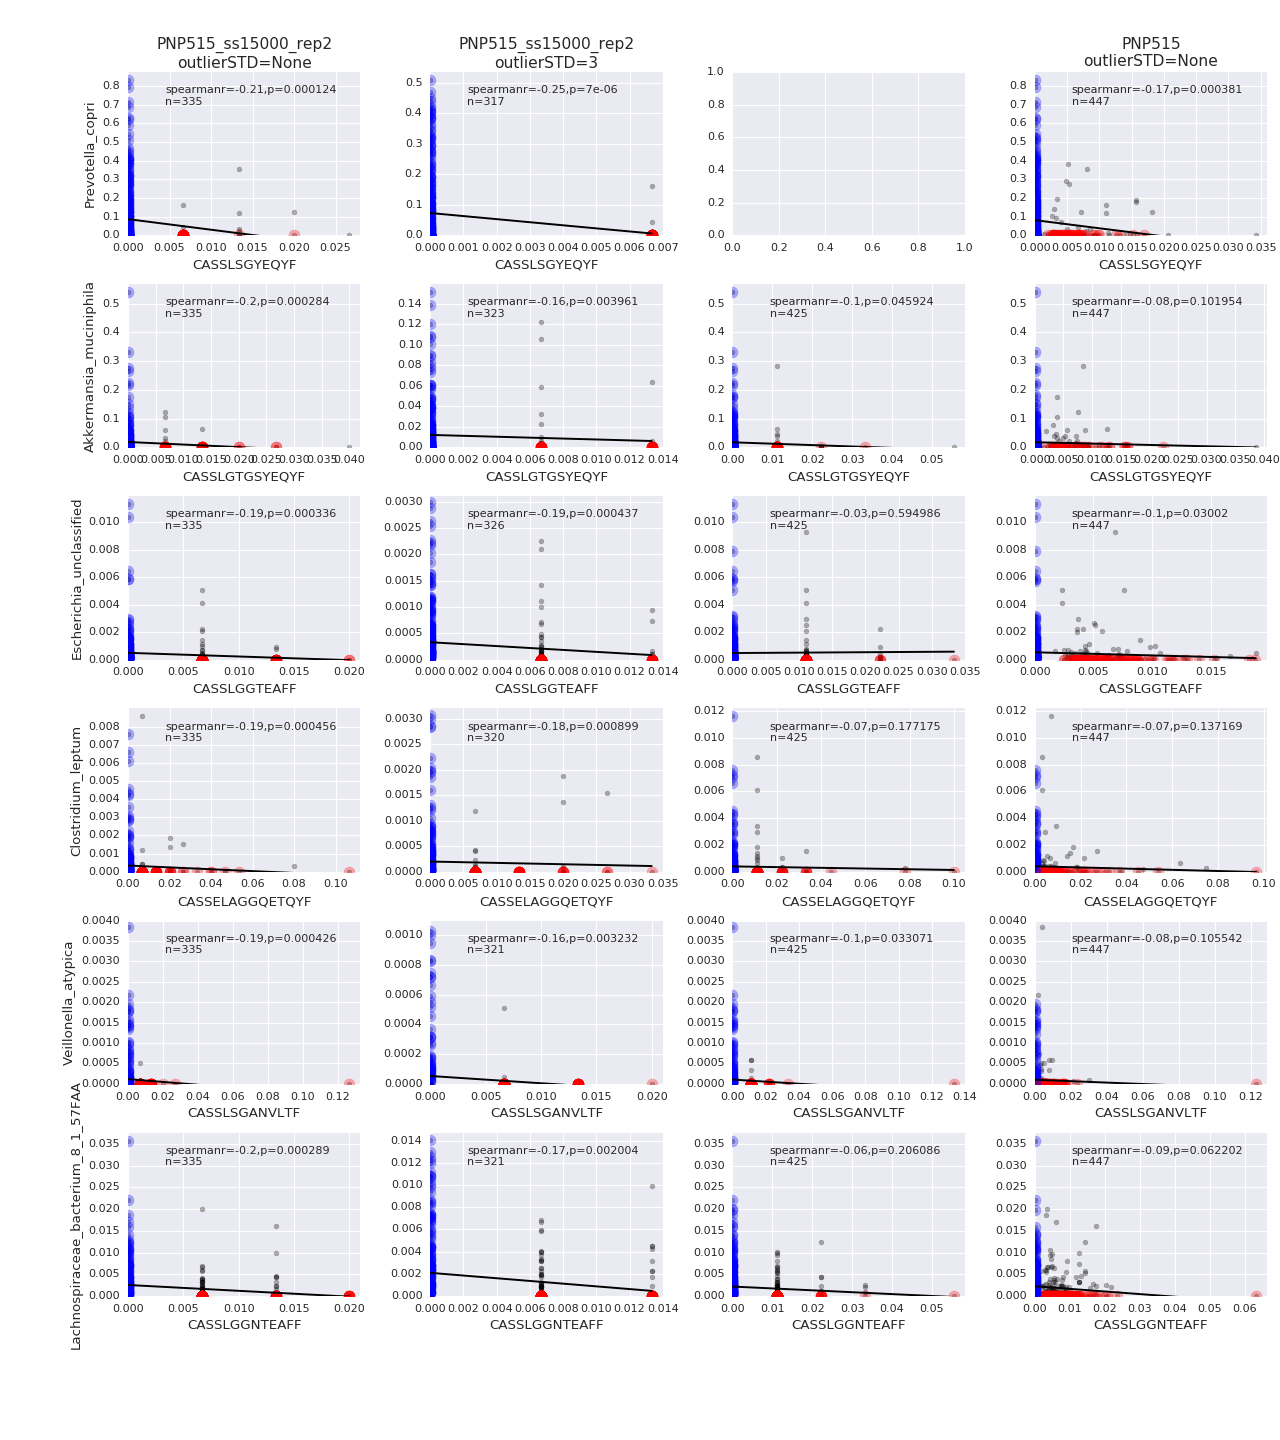

In [161]:
plt.show()

### high positive r, sig p, do not appear in fisher results since all samples have the species

In [162]:
topNegative4=spearman[(spearman['r_real']<0)&(spearman['nSamplesSpecies']==335)].sort_values(by=['real_p_Corr9998Perms']).head(6)
topNegative4

species              seq    r_real  nSamplesSeq  \
475  Subdoligranulum_unclassified    CASSLAGQETQYF -0.159453           53   
32           Ruminococcus_torques    CASSDSSTDTQYF -0.147813          102   
351  Subdoligranulum_unclassified      CASSSTYEQYF -0.137882           72   
54           Ruminococcus_torques  CASSELAGGTDTQYF -0.129168           82   
62           Ruminococcus_torques  CASSELAGGQETQYF -0.125187           83   
66           Ruminococcus_torques      CASSLADTQYF -0.120397           78   

     nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
475              335              53              0.004500   
32               335             102              0.010201   
351              335              72              0.010501   
54               335              82              0.017402   
62               335              83              0.018802   
66               335              78              0.026803   

     Sig by bonferroni corrected pVal  sig. by FDR=0.01  sig. by FDR=0.1  \
475                                 0                 0                0   
32                                  0                 0                0   
351                                 0                 0                0   
54                                  0                 0                0   
62                                  0                 0                0   
66                                  0                 0                0   

     sig. by FDR=0.25  
475                 0  
32                  0  
351                 0  
54                  0  
62                  0  
66                  0

In [163]:
color_binary=True
corrTest='spearman'

seqList=list(topNegative4['seq'])
speciesList=list(topNegative4['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=3
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)


             

##############
0 0 CASSLAGQETQYF Subdoligranulum_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSLAGQETQYF Subdoligranulum_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSLAGQETQYF Subdoligranulum_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099

##############
5 0 CASSLADTQYF Ruminococcus_torques
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 1 CASSLADTQYF Ruminococcus_torques
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 2 CASSLADTQYF Ruminococcus_torques
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrou

limit_output extension: Maximum message size of 10000 exceeded with 10120 characters

<IPython.core.display.Javascript object>


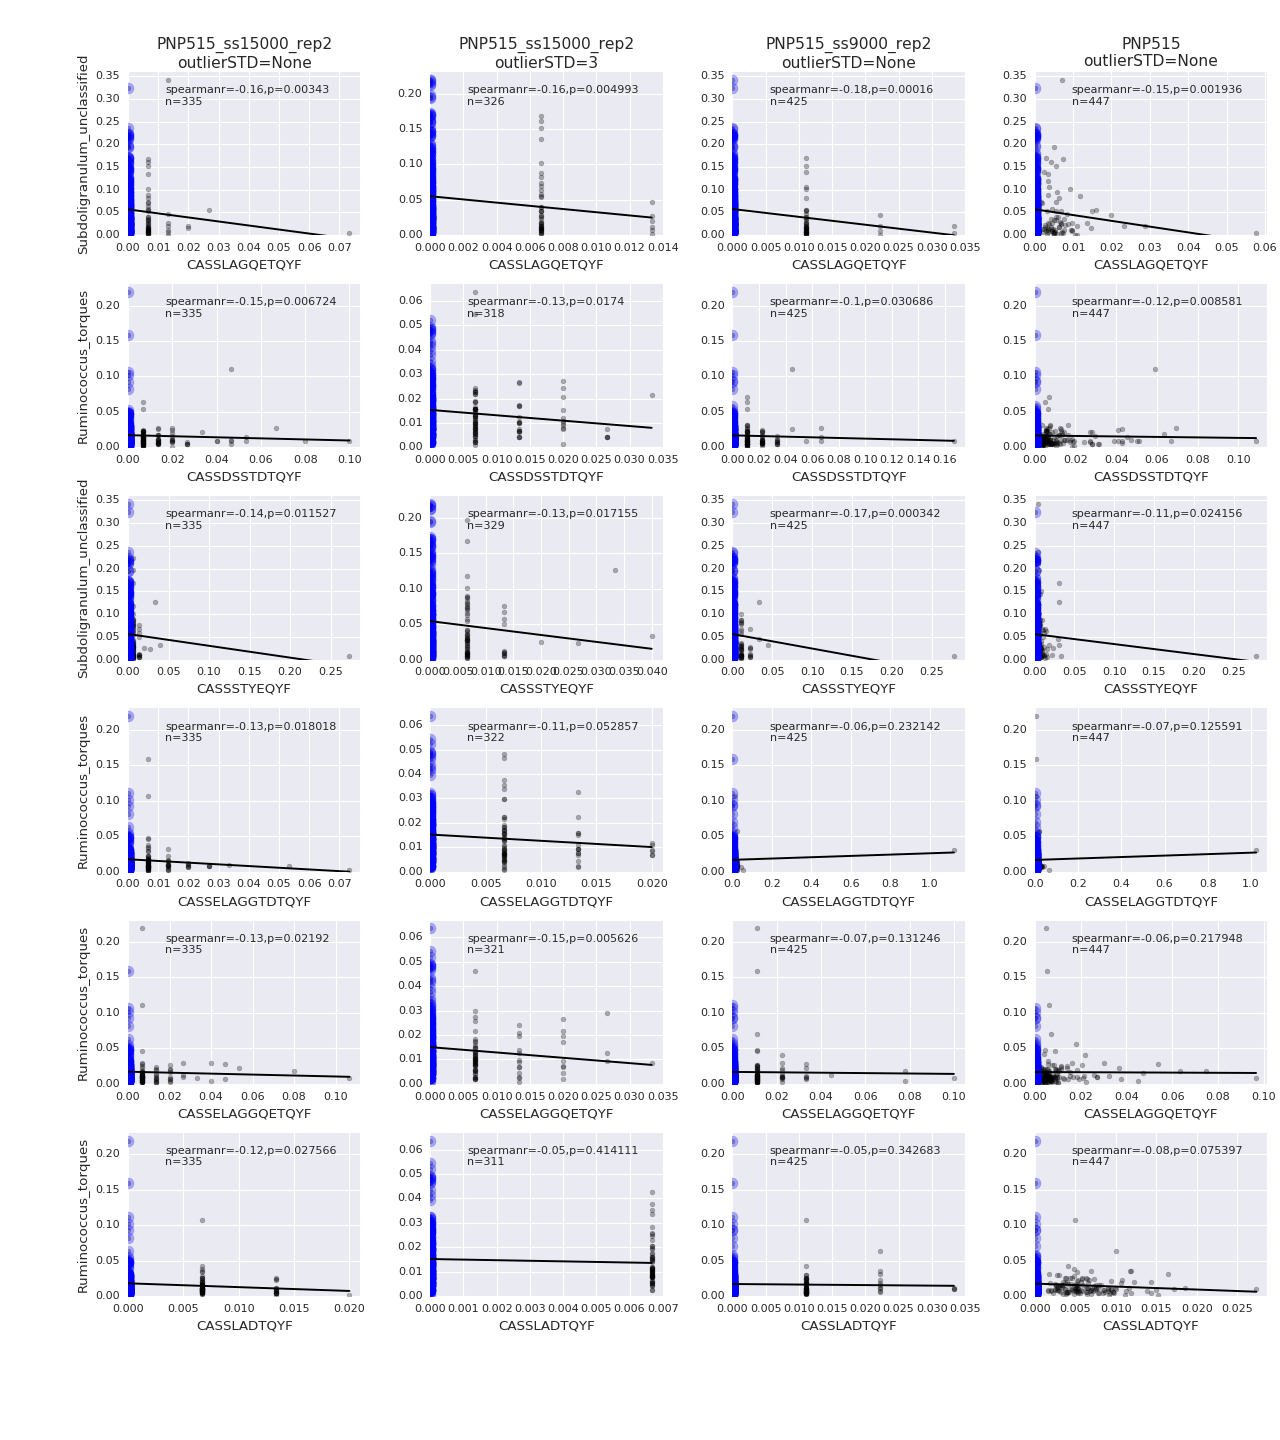

In [164]:
plt.show()

### almost all samples that have the sequence have the species - high positive log OR, not in the correlation

In [166]:
topNegative5=fisher[(fisher['log10OR_real'].astype('str')!='-inf')&(fisher['real_p_Fisher9999Perms']<0.001)].sort_values(by='log10OR_real').head(6)
topNegative5

species              seq  log10OR_real  \
34158             Coprobacillus_unclassified      CASSYQETQYF     -1.117639   
31856                    Veillonella_atypica    CASSLSGANVLTF     -0.934689   
33381              Turicibacter_unclassified    CASSVGGNTEAFF     -0.869071   
29492  Erysipelotrichaceae_bacterium_2_2_44A      CASSQTYEQYF     -0.863676   
23476           Parabacteroides_unclassified     CASSLEGETQYF     -0.595036   
22211                    Ruminococcus_gnavus  CASSGLAGGPDTQYF     -0.544068   

       speciesNegSeqNeg  speciesNegSeqPos  speciesPosSeqNeg  speciesPosSeqPos  \
34158               225                59                50                 1   
31856               212                64                57                 2   
33381               219                60                54                 2   
29492               219                50                64                 2   
23476               187                46                96                 6   
22211               184                46                98                 7   

       real_p_Fisher9999Perms  Sig by bonferroni corrected pVal  \
34158                  0.0002                                 0   
31856                  0.0001                                 0   
33381                  0.0005                                 0   
29492                  0.0006                                 0   
23476                  0.0009                                 0   
22211                  0.0009                                 0   

       sig. by FDR=0.1  sig. by FDR=0.25  
34158                0                 0  
31856                0                 0  
33381                0                 0  
29492                0                 0  
23476                0                 0  
22211                0                 0

In [169]:
color_binary=True
corrTest='spearman'

seqList=list(topNegative5['seq'])
speciesList=list(topNegative5['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=3
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)


             

##############
0 0 CASSYQETQYF Coprobacillus_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSYQETQYF Coprobacillus_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSYQETQYF Coprobacillus_unclassified
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging Use

##############
5 0 CASSGLAGGPDTQYF Ruminococcus_gnavus
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 1 CASSGLAGGPDTQYF Ruminococcus_gnavus
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
5 2 CASSGLAGGPDTQYF Ruminococcus_gnavus
##############
loading most updated Mb file...
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info 

<IPython.core.display.Javascript object>


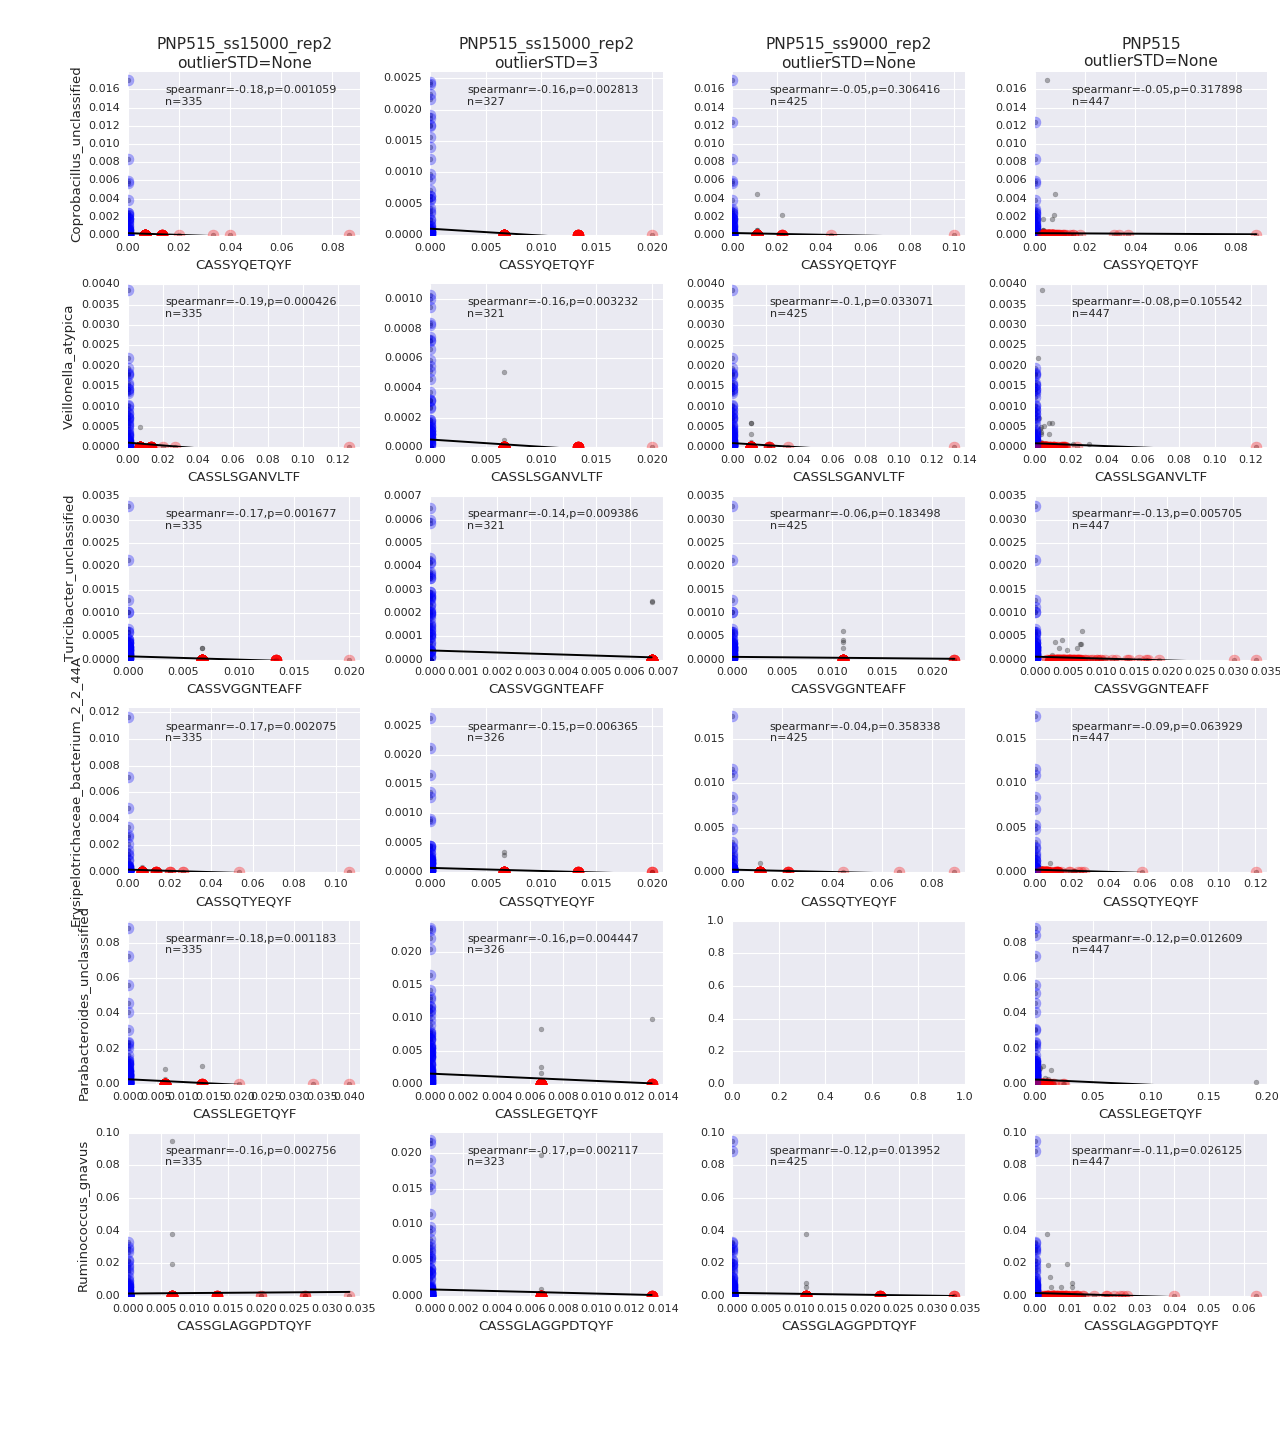

In [170]:
plt.show()

### r<-0.2, p<0.005

In [225]:
topNegative6=merged_tests[(merged_tests['r_real']<=-0.15)&(merged_tests['real_p_Corr9998Perms']<0.005)].sort_values(by=['r_real','log10OR_real']).head(6)
topNegative6

species             seq    r_real  nSamplesSeq  \
0                     Prevotella_copri    CASSLSGYEQYF -0.208157           50   
1              Akkermansia_muciniphila  CASSLGTGSYEQYF -0.197068           57   
2  Lachnospiraceae_bacterium_8_1_57FAA   CASSLGGNTEAFF -0.196836          136   
3             Escherichia_unclassified    CASSLGGTEAFF -0.194766           91   
4                  Veillonella_atypica   CASSLSGANVLTF -0.191441           66   
5               Bacteroides_salyersiae   CASSLDSYNEQFF -0.190959           63   

   nSamplesSpecies  nComSeqSpecies  real_p_Corr9998Perms  \
0              220              24                0.0002   
1              227              28                0.0003   
2              154              50                0.0005   
3              176              33                0.0004   
4               59               2                0.0005   
5              166              20                0.0009   

   Sig by bonferroni corrected pVal_correlation  sig. by FDR=0.01  \
0                                             0                 0   
1                                             0                 0   
2                                             0                 0   
3                                             0                 0   
4                                             0                 0   
5                                             0                 0   

   sig. by FDR=0.1_correlation               ...                \
0                            0               ...                 
1                            0               ...                 
2                            0               ...                 
3                            0               ...                 
4                            0               ...                 
5                            0               ...                 

     Reference_VDJDB  Score_VDJDB  Species_CMVpaper  Epitope species_CMVpaper  \
0  ['PMID:28636592']          [0]               NaN                       NaN   
1                NaN          NaN               NaN                       NaN   
2                NaN          NaN               NaN                       NaN   
3  ['PMID:28423320']          [0]               NaN                       NaN   
4                NaN          NaN               NaN                       NaN   
5                NaN          NaN               NaN                       NaN   

   Reference_CMVpaper  Score_CMVpaper  Species_McPAS  \
0                 NaN             NaN      ['Mouse']   
1                 NaN             NaN            NaN   
2                 NaN             NaN      ['Human']   
3                 NaN             NaN      ['Human']   
4                 NaN             NaN            NaN   
5                 NaN             NaN      ['Human']   

                Category_McPAS  \
0                ['Pathogens']   
1                          NaN   
2               ['Autoimmune']   
3  ['Pathogens', 'Autoimmune']   
4                          NaN   
5                ['Pathogens']   

                                     Pathology_McPAS  \
0                                      ['Influenza']   
1                                                NaN   
2                                 ['Celiac disease']   
3  ['Influenza', 'Celiac disease', 'Diabetes Type...   
4                                                NaN   
5                                      ['Influenza']   

                  PubMed.ID_McPAS  
0            [25804828, 28636592]  
1                             NaN  
2                      [29269859]  
3  [28636589, 29269859, 27942583]  
4                             NaN  
5                      [28636589]  

[6 rows x 32 columns]

In [226]:
dfName='topNegative6'
color_binary=True
corrTest='spearman'

seqList=list(topNegative6['seq'])
speciesList=list(topNegative6['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                    '%s/TCR_real_data/SubSampled15000data_rep1' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss15000_rep1','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        if j==2:
            onlyNextera=True
        else:
            onlyNextera=False 
        print '##############' 
        print i,j,seq,species
        print '##############'
        if len(seqList)<2:
            ax=axes[0]
        else:
            ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=5
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,onlyNextera,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
                if j==2:
                    ax.set_title('%s\noutlierSTD=%s\nOnly Nextera samples!' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)

figFolder='%s/TCR_real_data/seqSpeciesPairImages' %MyPath
if not isdir(figFolder):
    makedirs(figFolder)
figFile='%s/%s' %(figFolder,dfName)
fig.savefig(figFile,dpi=200)


             

##############
0 0 CASSLSGYEQYF Prevotella_copri
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSLSGYEQYF Prevotella_copri
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSLSGYEQYF Prevotella_copri
##############
loading most updated Mb file...filtered by libPrepMethod
loading B

##############
3 4 CASSLGGTEAFF Escherichia_unclassified
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
3 UserIDs have more than one BD
groupedDF length before dropping same person samples is 450
removing UserIDs: [3290, 447, 2363]
removing BD: [u'BD714', u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 447_2
##############
4 0 CASSLSGANVLTF Veillonella_atypica
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
4 1 CASSLSGANVLTF Veillonella_atypica
##############
loading most updated Mb file...NOT

limit_output extension: Maximum message size of 10000 exceeded with 10098 characters

### only nextera data:

In [221]:
topNegative7=merged_nextera[merged_nextera['r_real']<=-0.2].sort_values(by='r_real').head(6)
topNegative7

species              seq    r_real  nSamplesSeq  \
0  Bifidobacterium_adolescentis   CASSLGQNTGELFF -0.298027         32.0   
0            Eubacterium_hallii    CASSDRDTGELFF -0.266369         79.0   
0  Bacteroides_cellulosilyticus  CASSDSSGSYNEQFF -0.263904         36.0   
0    Streptococcus_thermophilus   CSARLAGGQETQYF -0.262314         47.0   
0        Roseburia_intestinalis   CASSLAGSTDTQYF -0.261156         22.0   
0        Bilophila_unclassified      CASSLNYGYTF -0.253750         32.0   

   nSamplesSpecies  nComSeqSpecies  
0            144.0            17.0  
0            177.0            79.0  
0            132.0            18.0  
0             93.0            15.0  
0            156.0            14.0  
0            155.0            26.0

In [222]:
dfName='topNegative7'
color_binary=True
corrTest='spearman'

seqList=list(topNegative7['seq'])
speciesList=list(topNegative7['species'])

datasetFolderList=['%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                   '%s/TCR_real_data/SubSampled15000data_rep2' %MyPath,
                    '%s/TCR_real_data/SubSampled15000data_rep1' %MyPath,
                   '%s/TCR_real_data/SubSampled9000data_rep2' %MyPath,
                   '%s/TCR_real_data' %MyPath]
datasetNameList=['PNP515_ss15000_rep2','PNP515_ss15000_rep2','PNP515_ss15000_rep1','PNP515_ss9000_rep2','PNP515']
hsize=4*len(datasetNameList)
vsize=3*len(seqList)
fig, axes=plt.subplots(nrows=len(seqList), ncols=len(datasetFolderList),figsize=(hsize,vsize))


for i in range(len(seqList)):
    seq=seqList[i]
    species=speciesList[i]
    for j in range(len(datasetNameList)):
        if j==2:
            onlyNextera=True
        else:
            onlyNextera=False 
        print '##############' 
        print i,j,seq,species
        print '##############' 
        ax=axes[i,j]
        datasetFolder=datasetFolderList[j]
        datasetName=datasetNameList[j]
        if j==1:
            outlierSTD=5
        else:
            outlierSTD=None
        try:
            ax=plot_seq_species_scatter(ax,corrTest,datasetFolder, datasetName, seq, species, color_binary,onlyNextera,outlierSTD)
            if i==0:
                ax.set_title('%s\noutlierSTD=%s' %(datasetName,outlierSTD),fontsize=14)
                if j==2:
                    ax.set_title('%s\noutlierSTD=%s\nOnly Nextera samples!' %(datasetName,outlierSTD),fontsize=14)
            if j!=0:
                ax.set_ylabel('')
        except KeyError:
            print 'seq %s do not exist in dataset %s' %(seq,datasetName)
            continue

fig.subplots_adjust(left=0.1, bottom=None, right=0.99, top=0.95,
    wspace=0.3, hspace=0.3)

figFolder='%s/TCR_real_data/seqSpeciesPairImages' %MyPath
if not isdir(figFolder):
    makedirs(figFolder)
figFile='%s/%s' %(figFolder,dfName)
fig.savefig(figFile,dpi=200)


             

##############
0 0 CASSLGQNTGELFF Bifidobacterium_adolescentis
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 1 CASSLGQNTGELFF Bifidobacterium_adolescentis
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 UserIDs have more than one BD
groupedDF length before dropping same person samples is 337
removing UserIDs: [447, 2363]
removing BD: [u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 335_2
##############
0 2 CASSLGQNTGELFF Bifidobacterium_adolescentis
##############
loading most updated Mb 

number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
3 UserIDs have more than one BD
groupedDF length before dropping same person samples is 428
removing UserIDs: [3290, 447, 2363]
removing BD: [u'BD714', u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 425_2
##############
3 4 CSARLAGGQETQYF Streptococcus_thermophilus
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
3 UserIDs have more than one BD
groupedDF length before dropping same person samples is 450
removing UserIDs: [3290, 447, 2363]
removing BD: [u'BD714', u'BD838', u'BD938']
groupedDF shape after dropping same person samples is 447_2
##############
4 0 CASSLAGSTDTQYF Roseburia_intestinalis
##############
loading most updated Mb file...NOT filtered by libPrepMethod
loading BD_FD table
number of BD-UserID pairs is 1099
merging UserID info to BDgrouped table:
2 Us

limit_output extension: Maximum message size of 10000 exceeded with 10282 characters